# 1. 개발 환경 세팅하기

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score


In [42]:
import matplotlib.font_manager as fm

# 사용할 한글 폰트 파일 경로 지정 (예: 윈도우의 Malgun Gothic)
font_path = 'C:/Windows/Fonts/malgun.ttf'

# 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path).get_name()

print(f"가져온 폰트 이름: {font_name}")

# matplotlib의 rcParams 설정을 통해 폰트 변경
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지 설정

print(f"matplotlib 폰트 설정 완료: {plt.rcParams['font.family']}")

가져온 폰트 이름: Malgun Gothic
matplotlib 폰트 설정 완료: ['Malgun Gothic']


# 파일 불러오기

In [43]:
df = "C:/Users/PC/Documents/codeit_study/train_df.csv"

In [44]:
try:
    df = pd.read_csv(df, encoding='utf-8', on_bad_lines='skip')
    print("UTF-8 인코딩으로 데이터 로드에 성공했습니다.")
except UnicodeDecodeError:
    df = pd.read_csv(df, encoding='cp949', on_bad_lines='skip')
    print("CP949 인코딩으로 데이터 로드에 성공했습니다.")

UTF-8 인코딩으로 데이터 로드에 성공했습니다.


# 데이터 확인 및 전처리

## 체감온도 전처리

In [45]:
import numpy as np
import pandas as pd

# 날짜형 변환 및 월 정보 추가
df['date_dt'] = pd.to_datetime(df['date_dt'])
df['month'] = df['date_dt'].dt.month

# 여름철 체감온도 함수 (5~9월)
def summer_chi(ta, rh):
    try:
        tw = (
            ta * np.arctan(0.151977 * np.sqrt(rh + 8.313659)) +
            np.arctan(ta + rh) -
            np.arctan(rh - 1.676331) +
            0.00391838 * rh ** 1.5 * np.arctan(0.023101 * rh) -
            4.686035
        )
        chi = -0.2442 + 0.55399 * tw + 0.45535 * ta - 0.0022 * tw**2 - 0.00278 * tw * ta + 3.0
        return chi
    except:
        return np.nan

# 겨울철 체감온도 함수 (10~4월)
def winter_chi(ta, v):
    try:
        v_16 = v ** 0.16
        chi = 13.12 + 0.6215 * ta - 11.37 * v_16 + 0.3965 * v_16 * ta
        return chi
    except:
        return np.nan

# 전체 체감온도 계산
def calculate_chi(row):
    if 5 <= row['month'] <= 9:
        return summer_chi(row['ta'], row['hm'])
    else:
        return winter_chi(row['ta'], row['ws'])

# 계산 적용
df['calculated_chi'] = df.apply(calculate_chi, axis=1)

# 반올림
df['chi_rounded'] = df['chi'].round(1)
df['calculated_chi_rounded'] = df['calculated_chi'].round(1)

# 일치 여부 확인
df['is_same'] = df['chi_rounded'] == df['calculated_chi_rounded']
match_rate = df['is_same'].mean()

# 결과 출력
print(f'체감온도(소수 1자리 기준) 일치율: {match_rate * 100:.2f}%')

체감온도(소수 1자리 기준) 일치율: 0.49%


In [46]:
# 차이 계산 (반올림 전 기준 차이)
df['chi_diff'] = df['chi'] - df['calculated_chi']

# 반올림 후 기준으로 다르다고 판단된 경우 필터링
not_matched_df = df[df['is_same'] == False]

# 차이 통계
diff_stats = not_matched_df['chi_diff'].describe()

# 결과 출력
print("체감온도 불일치 구간 통계 (소수점 전 기준 차이):")
print(diff_stats)

# 절댓값 기준 평균 오차도 확인
mean_abs_error = not_matched_df['chi_diff'].abs().mean()
print(f"\n불일치한 경우 평균 절댓값 차이: {mean_abs_error:.2f}°C")


체감온도 불일치 구간 통계 (소수점 전 기준 차이):
count    1.551299e+07
mean    -6.075349e-02
std      3.256133e+00
min     -2.067645e+01
25%     -2.263946e+00
50%     -6.716838e-01
75%      2.750149e+00
max      8.363749e+00
Name: chi_diff, dtype: float64

불일치한 경우 평균 절댓값 차이: 2.70°C


| 통계항목           | 값 (°C)         | 의미                                                     |
| -------------- | -------------- | ------------------------------------------------------ |
| `count`        | **15,512,999** | 비교에 사용된 데이터 개수                                         |
| `mean`         | **-0.06°C**    | 평균적으로 계산된 chi가 실제보다 약간 **높다**는 뜻 (실제 chi - 계산 chi < 0) |
| `std`          | **3.26°C**     | 오차의 표준편차. 대부분 값은 ±3.26°C 안에 분포                         |
| `min`          | **-20.68°C**   | 계산된 값보다 실제 chi가 20.68도 **낮은 경우**가 있었다는 뜻               |
| `25%`          | **-2.26°C**    | 하위 25%는 오차가 -2.26°C 이하                                 |
| `50%` (median) | **-0.67°C**    | 절반은 -0.67°C 이하                                         |
| `75%`          | **+2.75°C**    | 상위 25%는 오차가 2.75°C 이상                                  |
| `max`          | **+8.36°C**    | 계산된 값보다 실제 chi가 8.36도 **높은 경우**가 있었다는 뜻                |


- 차이가 큰 이유 
    - 모델링 과정 중 잘못 예측한 경우 ? 
        - 모델링 과정 중 문제가 있었다고 하더라도 일치율이 0.49면 좀 .... 내가 따로 구한 것을 chi 라고 생각하고 진행을 해야할까 ? 
- 기존 체감온도 내가 구한 체감온도로 대체 후 삭제

In [47]:
df['chi'] = df['calculated_chi']
df = df.drop(columns=['calculated_chi_rounded', 'chi_rounded', 'calculated_chi', 'chi_diff'], axis=1)

## 불쾌지수

In [48]:
# 불쾌지수 계산 함수
def calculate_discomfort_index(ta, rh):
    try:
        return 0.81 * ta + 0.01 * rh * (0.99 * ta - 14.3) + 46.3
    except:
        return np.nan

# 적용
df['discomfort_index'] = df.apply(lambda row: calculate_discomfort_index(row['ta'], row['hm']), axis=1)

# 예시 출력
print(df[['ta', 'hm', 'discomfort_index']].head())


    ta      hm  discomfort_index
0 -9.6  52.477         26.032375
1 -9.3  70.292         22.243460
2 -9.3  55.452         25.731898
3 -9.1  51.202         26.994326
4 -8.5  62.856         25.137260


- 불쾌지수 

| DI 값  | 해석               |
| ----- | ---------------- |
| 68 이하 | 쾌적               |
| 68–75 | 불쾌감 느끼는 사람 증가 시작 |
| 75–80 | 절반 이상이 불쾌감 느낌    |
| 80 이상 | 대부분 불쾌감을 느낌      |


In [49]:
# 불쾌지수 등급 분류
def classify_di(di):
    if di <= 68:
        return '쾌적'
    elif di <= 75:
        return '불쾌 증가'
    elif di <= 80:
        return '절반 이상 불쾌'
    else:
        return '매우 불쾌'

df['di_level'] = df['discomfort_index'].apply(classify_di)

# 확인
print(df[['discomfort_index', 'di_level']].value_counts())

discomfort_index  di_level
69.793510         불쾌 증가       1758
69.253807         불쾌 증가       1604
70.333213         불쾌 증가       1574
70.693015         불쾌 증가       1516
71.232718         불쾌 증가       1468
                              ... 
67.228435         쾌적             1
71.603009         불쾌 증가          1
46.025083         쾌적             1
76.593869         절반 이상 불쾌       1
45.043172         쾌적             1
Name: count, Length: 475650, dtype: int64


## 강수량

- 시간 강수량을 다 더하면 일 강수량이 나와야 하지 않을까 ? 

In [50]:
# 시간 강수량 합계 계산 (하루 단위)
hourly_rain_sum = df.groupby(['date_dt', 'station_name'])['rn_hr1'].sum().reset_index()
hourly_rain_sum.rename(columns={'rn_hr1': 'daily_rn_hr1_sum'}, inplace=True)


In [51]:
# 일 강수량 정보 추출
daily_rn_day = df[['date_dt', 'station_name', 'rn_day']].drop_duplicates()


In [52]:
# 병합
rain_compare = pd.merge(hourly_rain_sum, daily_rn_day, on=['date_dt', 'station_name'])

# 차이 계산
rain_compare['diff'] = (rain_compare['daily_rn_hr1_sum'] - rain_compare['rn_day']).round(2)


In [53]:
# 일치하는 경우 비율
match_rate = (rain_compare['diff'].abs() < 0.01).mean() * 100
print(f"일 강수량(rn_day)과 시간 강수량 합(rn_hr1)의 일치 비율: {match_rate:.2f}%")

# 불일치 샘플
rain_compare[rain_compare['diff'].abs() >= 0.01].head()


일 강수량(rn_day)과 시간 강수량 합(rn_hr1)의 일치 비율: 27.92%


,date_dt,station_name,daily_rn_hr1_sum,rn_day,diff
86,2021-01-01,동두천,0.028,0.890,-0.86
87,2021-01-01,동두천,0.028,0.000,0.03
88,2021-01-01,동두천,0.028,0.040,-0.01
89,2021-01-01,동두천,0.028,0.170,-0.14
90,2021-01-01,동두천,0.028,0.113,-0.08


In [54]:
# 1. 일 강수량 계산 (date_dt + station_name 기준)
new_rn_day = df.groupby(['date_dt', 'station_name'])['rn_hr1'].sum().reset_index()
new_rn_day.rename(columns={'rn_hr1': 'rn_day_new'}, inplace=True)

# 2. 원본 데이터와 병합
df = pd.merge(df.drop(columns=['rn_day']), new_rn_day, on=['date_dt', 'station_name'], how='left')

# 3. 컬럼 순서 정리 (선택)
cols = df.columns.tolist()
# rn_day_new를 rn_day로 이름 변경하여 기존 위치로
cols[cols.index('rn_day_new')] = 'rn_day'
df.columns = cols
df.rename(columns={'rn_day_new': 'rn_day'}, inplace=True)

# 4. 확인
print(df[['date_dt', 'station_name', 'hour', 'rn_hr1', 'rn_day']].head(10))


     date_dt station_name  hour  rn_hr1  rn_day
0 2021-01-01          서울역     0     0.0     0.0
1 2021-01-01          서울역     5     0.0     0.0
2 2021-01-01          서울역     6     0.0     0.0
3 2021-01-01          서울역     7     0.0     0.0
4 2021-01-01          서울역     8     0.0     0.0
5 2021-01-01          서울역     9     0.0     0.0
6 2021-01-01          서울역    10     0.0     0.0
7 2021-01-01          서울역    11     0.0     0.0
8 2021-01-01          서울역    12     0.0     0.0
9 2021-01-01          서울역    13     0.0     0.0


## 출근 퇴근 시간대 구분

In [55]:
df['year'] = pd.to_datetime(df['date_dt']).dt.year
df['month'] = pd.to_datetime(df['date_dt']).dt.month
df['day'] = pd.to_datetime(df['date_dt']).dt.day
grouped_all = df.groupby(['year', 'month', 'hour'])[
    ['congestion', 'ta', 'hm', 'si', 'rn_hr1']
].mean().reset_index()

In [56]:
def assign_commute_time(hour):
    if 7 <= hour <= 9:
        return '출근'
    elif 17 <= hour <= 19:
        return '퇴근'
    else:
        return '기타'

df['출퇴근시간'] = df['hour'].apply(assign_commute_time)

## 비가 오는데 습도가 0 ? 

In [57]:
# 비가 오는데 습도가 0인 경우 필터링
weird_humidity = df[(df['rn_hr1'] > 0) & (df['hm'] == 0)]

print(f"이상 케이스 수: {len(weird_humidity)}")
display(weird_humidity[['date_dt', 'station_name', 'hour', 'rn_hr1', 'hm']].head())


이상 케이스 수: 0


,date_dt,station_name,hour,rn_hr1,hm


- 열차 혼합도란 ? 
- ex ) 1시간동안 지나가는 열차들의 평균 혼잡도 = congesition
- 즉, 정원 대비 승차 인원으로 승차인과 좌석수가 일치할 경우 혼잡도를 34%로 산정한다. 
- 국토교통부의 지하철 혼잡도 기준 한 칸당 160명 기준(호설별 정원에 따라 상의하다.)

# EDA

## 통합 EDA

count    1.558983e+07
mean     2.263745e+01
std      1.924069e+01
min      0.000000e+00
25%      9.000000e+00
50%      1.900000e+01
75%      3.100000e+01
max      2.890000e+02
Name: congestion, dtype: float64


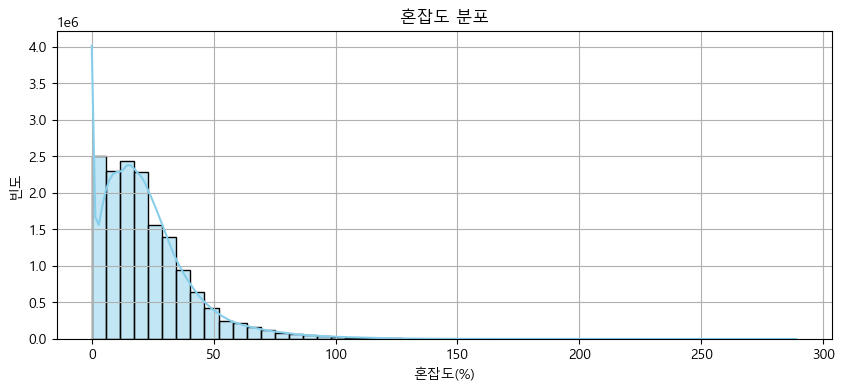

In [58]:
print(df['congestion'].describe())

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.histplot(df['congestion'], bins=50, kde=True, color='skyblue')
plt.title('혼잡도 분포')
plt.xlabel('혼잡도(%)')
plt.ylabel('빈도')
plt.grid(True)
plt.show()

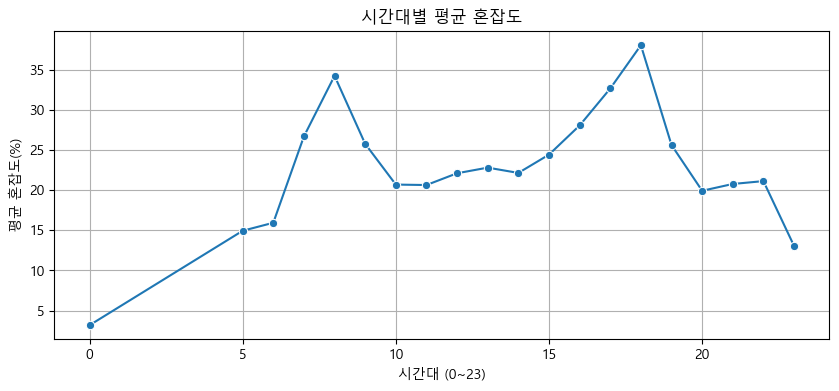

In [59]:
hourly_mean = df.groupby('hour')['congestion'].mean()

plt.figure(figsize=(10, 4))
sns.lineplot(x=hourly_mean.index, y=hourly_mean.values, marker='o')
plt.title("시간대별 평균 혼잡도")
plt.xlabel("시간대 (0~23)")
plt.ylabel("평균 혼잡도(%)")
plt.grid(True)
plt.show()


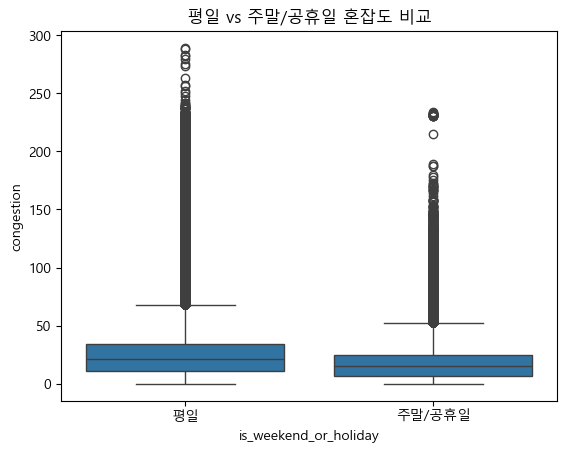

In [60]:
sns.boxplot(x='is_weekend_or_holiday', y='congestion', data=df)
plt.xticks([0, 1], ['평일', '주말/공휴일'])
plt.title("평일 vs 주말/공휴일 혼잡도 비교")
plt.show()


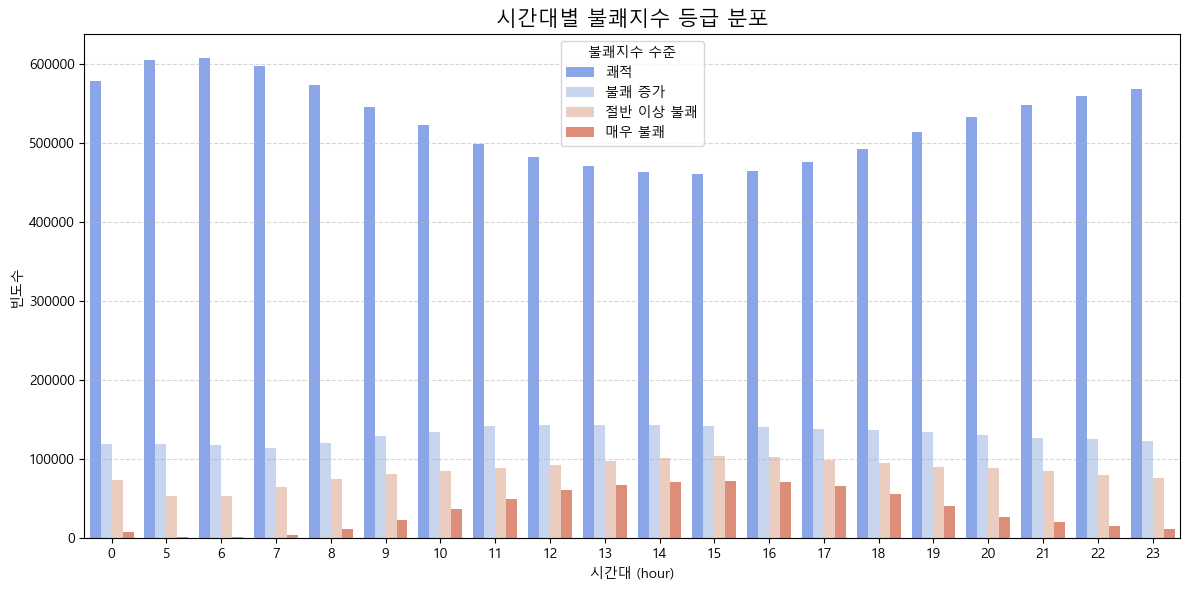

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시간대별 불쾌지수 카테고리 분포
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='hour', hue='di_level', order=sorted(df['hour'].unique()), palette='coolwarm')

plt.title('시간대별 불쾌지수 등급 분포', fontsize=15)
plt.xlabel('시간대 (hour)')
plt.ylabel('빈도수')
plt.legend(title='불쾌지수 수준')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 평일 / 휴일 분류 EDA

In [62]:
# 데이터 분할
df_weekday = df[df['is_weekend_or_holiday'] == 0]
df_weekend = df[df['is_weekend_or_holiday'] == 1]

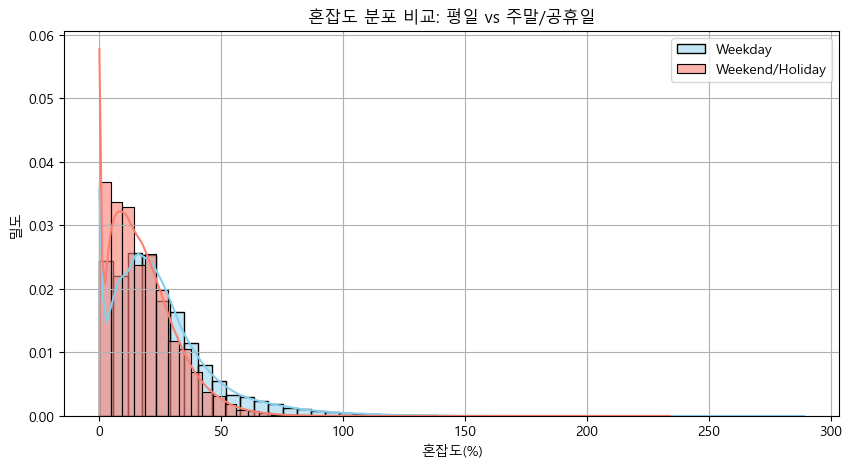

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df_weekday['congestion'], color='skyblue', label='Weekday', stat='density', bins=50, kde=True)
sns.histplot(df_weekend['congestion'], color='salmon', label='Weekend/Holiday', stat='density', bins=50, kde=True, alpha=0.6)
plt.title("혼잡도 분포 비교: 평일 vs 주말/공휴일")
plt.xlabel("혼잡도(%)")
plt.ylabel("밀도")
plt.legend()
plt.grid(True)
plt.show()

In [64]:
print("📌 혼잡도 통계 요약")
print("▶ 평일")
print(df_weekday['congestion'].describe())
print("\n▶ 주말/공휴일")
print(df_weekend['congestion'].describe())


📌 혼잡도 통계 요약
▶ 평일
count    1.059600e+07
mean     2.505205e+01
std      2.088204e+01
min      0.000000e+00
25%      1.100000e+01
50%      2.100000e+01
75%      3.400000e+01
max      2.890000e+02
Name: congestion, dtype: float64

▶ 주말/공휴일
count    4.993838e+06
mean     1.751410e+01
std      1.385104e+01
min      0.000000e+00
25%      7.000000e+00
50%      1.500000e+01
75%      2.500000e+01
max      2.340000e+02
Name: congestion, dtype: float64


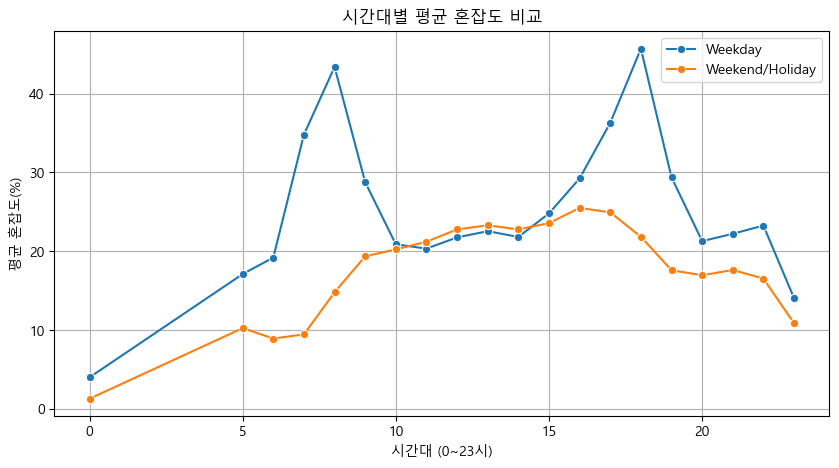

In [65]:
weekday_hourly = df_weekday.groupby('hour')['congestion'].mean()
weekend_hourly = df_weekend.groupby('hour')['congestion'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=weekday_hourly.index, y=weekday_hourly.values, label='Weekday', marker='o')
sns.lineplot(x=weekend_hourly.index, y=weekend_hourly.values, label='Weekend/Holiday', marker='o')
plt.title("시간대별 평균 혼잡도 비교")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("평균 혼잡도(%)")
plt.grid(True)
plt.legend()
plt.show()


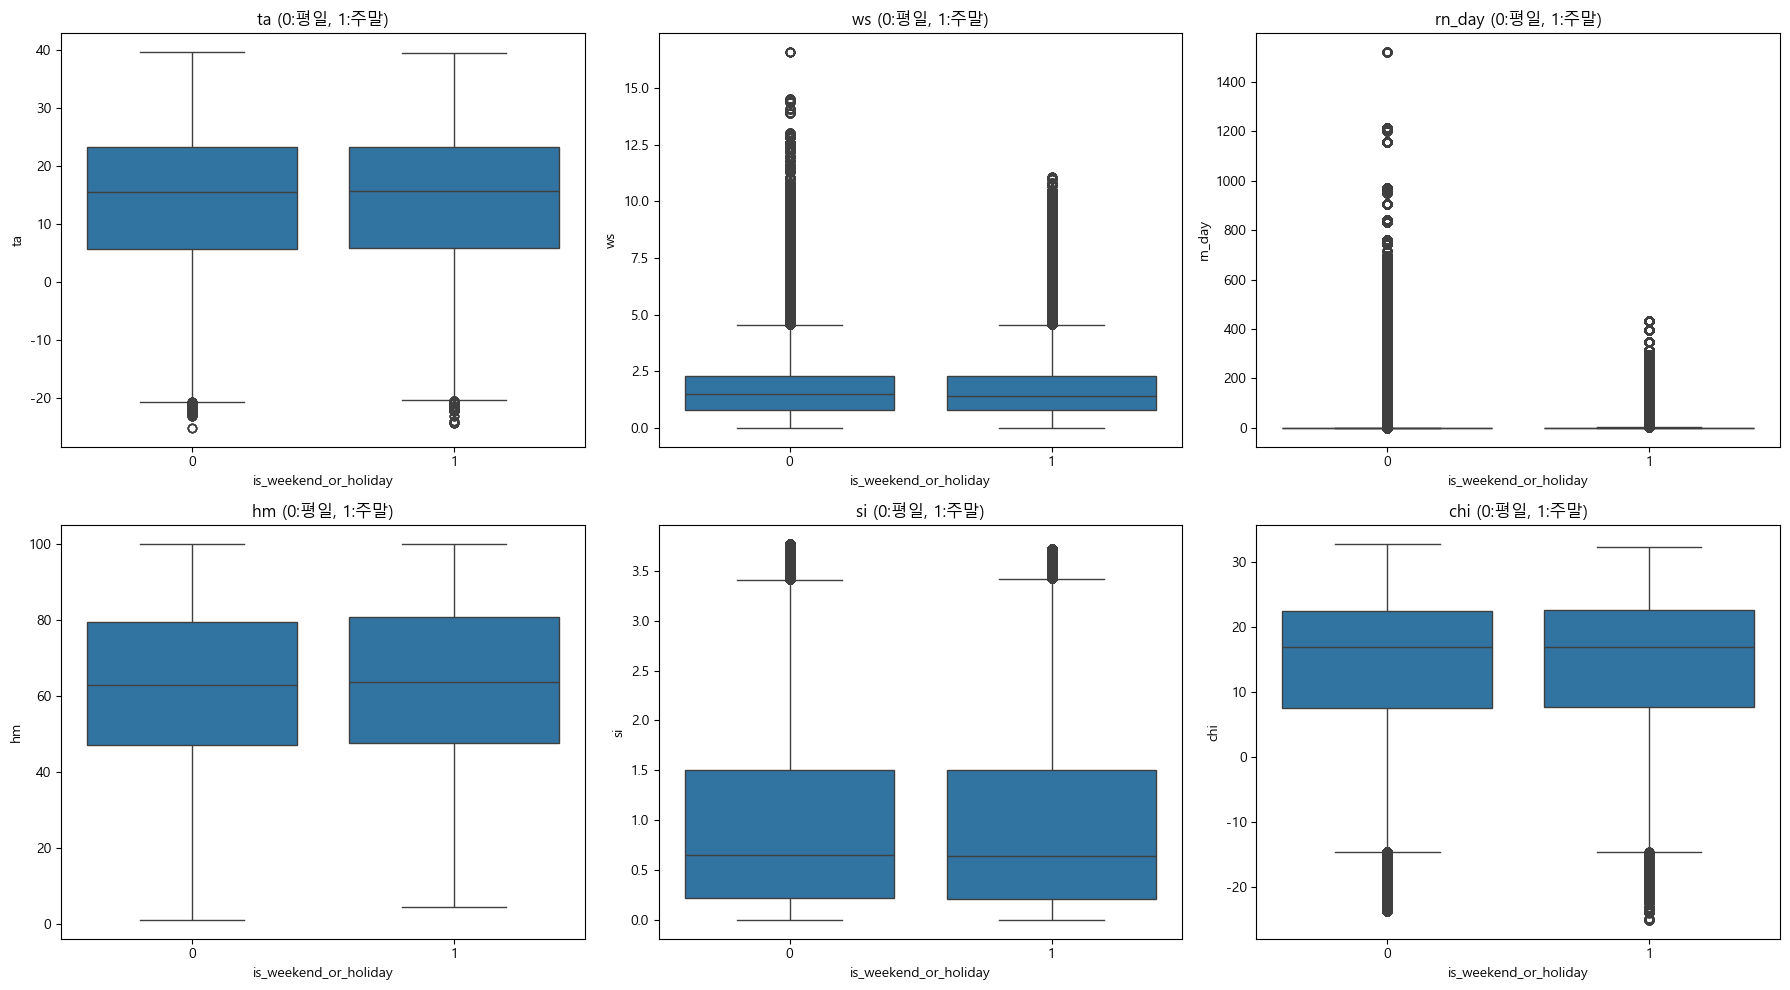

In [66]:
weather_cols = ['ta', 'ws', 'rn_day', 'hm', 'si', 'chi']

plt.figure(figsize=(18, 10))
for i, col in enumerate(weather_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df, x='is_weekend_or_holiday', y=col)
    plt.title(f"{col} (0:평일, 1:주말)")
plt.tight_layout()
plt.show()


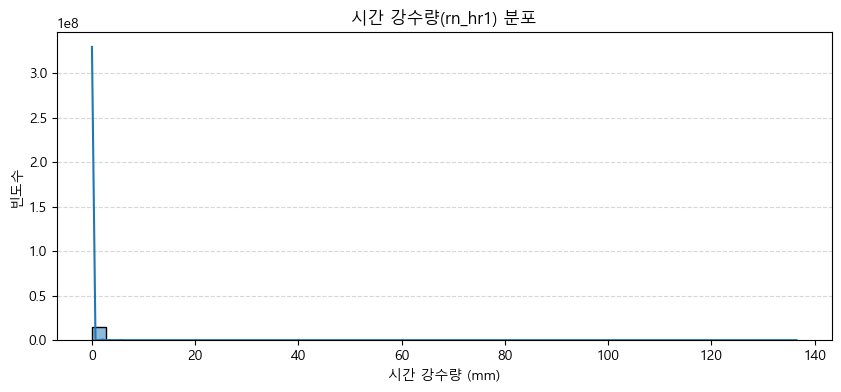

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.histplot(df['rn_hr1'], bins=50, kde=True)
plt.title('시간 강수량(rn_hr1) 분포')
plt.xlabel('시간 강수량 (mm)')
plt.ylabel('빈도수')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()


---

- 모델링을 돌린다면 ? 
    - 혼잡도를 그대로 숫자값(연속형)으로 예측하는 것
    - 구간을 나눠서 범주형(분류)으로 예측하는 것

- 각각 최적의 상황과 권장 방식

| 상황                           | 권장 방식 | 이유                   |
| ---------------------------- | ----- | -------------------- |
| 혼잡도가 세밀한 수치로 필요한 경우          | 회귀    | 예: 최적 스케줄링 알고리즘에 사용  |
| 사용자 알림용 등 **해석 용이성**이 중요한 경우 | 분류    | 예: “지금 혼잡도가 매우 높습니다” |
| 값의 분포가 불균형하거나 노이즈가 많은 경우     | 분류    | 이상치 영향 완화 가능         |

- 정리 
    - ✔️ 비즈니스 목적이 “알기 쉬운 혼잡 등급 제공”이라면 → 분류가 좋고
    - ✔️ 정밀한 수치가 필요한 최적화나 시뮬레이션이 목적이라면 → 회귀가 좋습니다

- 회귀와 분류는 목적이 다르고, 출력값도 다르며, 평가 방식도 완전히 다르기 때문에 각각 따로 검증을 해야한다.

| 항목    | 회귀 모델         | 분류 모델                    |
| ----- | ------------- | ------------------------ |
| 목표값   | 수치 (ex. 37.2) | 범주 (ex. Low/Medium/High) |
| 대표 지표 | RMSE, R², MAE | Accuracy, F1-score, AUC  |
| 해석    | 예측값 자체가 의미    | 예측 클래스의 맞춤 여부            |
| 검증 방식 | 수치 기반 오차 측정   | 맞춘/못 맞춘 비율 측정            |


- RMSE에 대한 설명이 안내서에 있는 거로 보아 회귀 모델을 사용 하라는 것이 주 목표인 것 같다. 


- 모델링 할 때 필요한 순서 ! 
    - 필요한 변수 선택 및 가공을 해야 할 필요성이 있다.(변수 선택을 어떤 방법으로 ??)
        - 변수 선택을 어떤 방법으로 ??
        - 상업지구인지 아닌지 나눌 필요성 있나 ? 

- 모델링을 한다면 ? 
    - 입력 (예시) : 역, 기온, 체감온도, 불쾌지수, 시간, 노선
    - 출력 : 혼잡도
- 필요할까 ? 
    - 변수 조합별 혼잡도 차이 분석
        - 특정 노선 + 특정 시간데 + 상업 지구 방향 -> 혼잡도가 높은가 ? 
        - 불쾌지수가 높을수록 혼잡도가 높아지는가 ? 

## 출퇴근시간 EDA

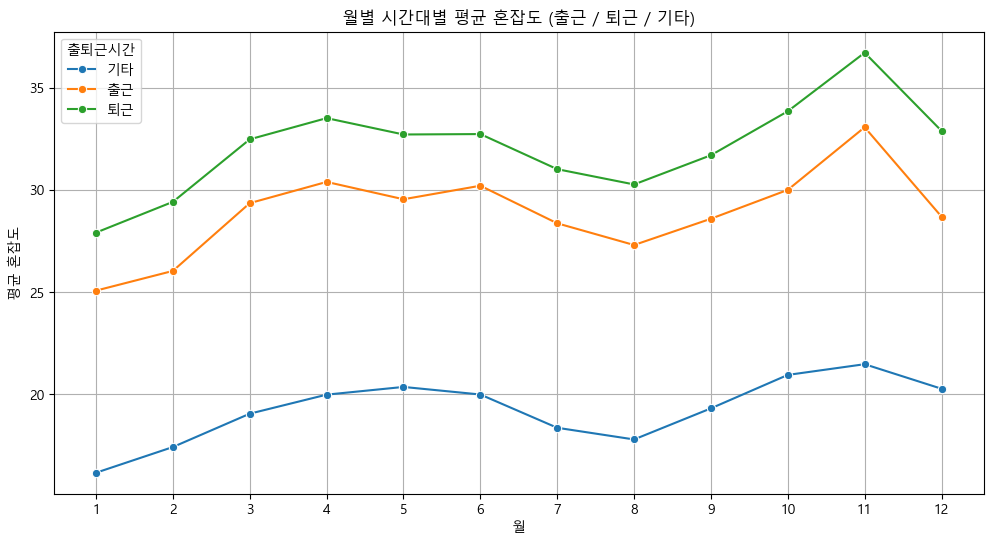

In [68]:
# 출근과 퇴근에도 혼잡도 차이가 있을까?
# 월별 + 출근or퇴근 기준 평균 혼잡도
monthly_all = df.groupby(['month', '출퇴근시간'])['congestion'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_all, x='month', y='congestion', hue='출퇴근시간', marker='o')
plt.title('월별 시간대별 평균 혼잡도 (출근 / 퇴근 / 기타)')
plt.xlabel('월')
plt.ylabel('평균 혼잡도')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

- 퇴근시간대가 가장 혼잡도가 높고 11월이 가장 혼잡도가 높은것을 확인할 수 있다.
- 혼잡도와 관련해서 비출퇴근시간이 더 상관관계가 높음 하지만 다 낮음

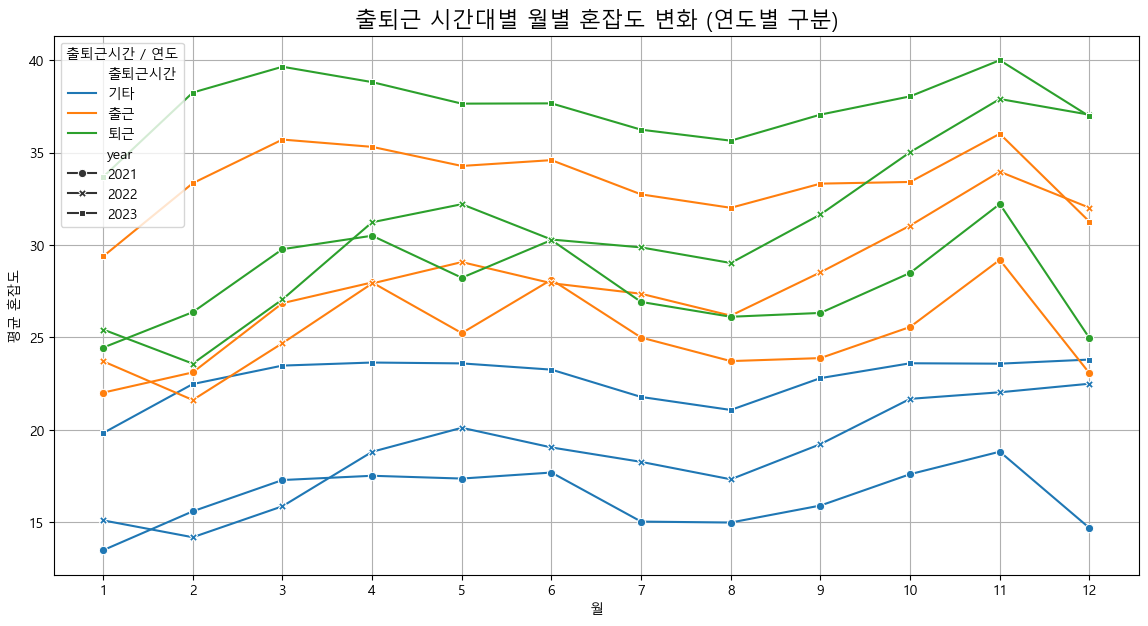

In [69]:
monthly_trend = df.groupby(['year', 'month', '출퇴근시간'])['congestion'].mean().reset_index()


plt.figure(figsize=(14, 7))
sns.lineplot(
    data=monthly_trend,
    x='month',
    y='congestion',
    hue='출퇴근시간',
    style='year',
    markers=True,
    dashes=False
)
plt.title('출퇴근 시간대별 월별 혼잡도 변화 (연도별 구분)', fontsize=16)
plt.xlabel('월')
plt.ylabel('평균 혼잡도')
plt.xticks(range(1, 13))
plt.legend(title='출퇴근시간 / 연도')
plt.grid(True)
plt.show()

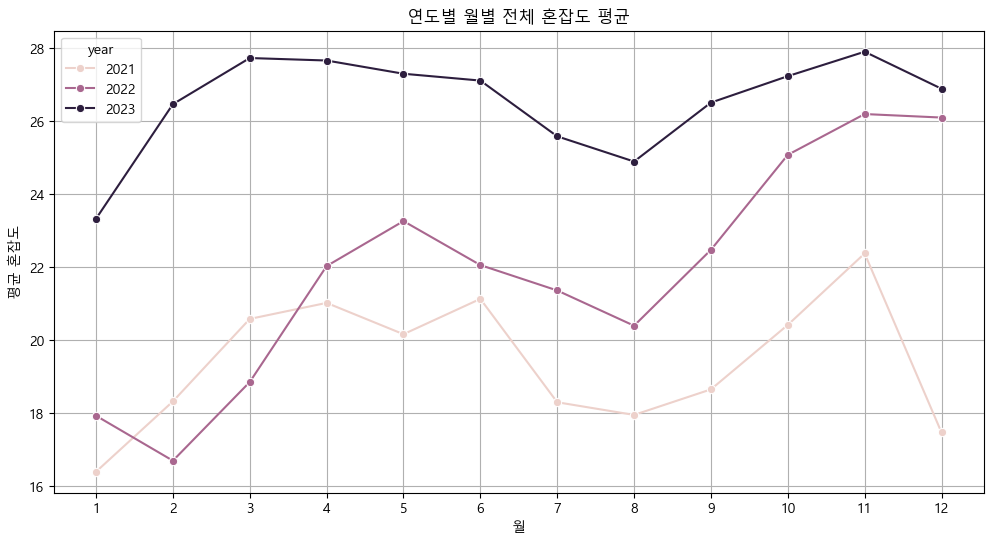

In [70]:
monthly_overall = df.groupby(['year', 'month'])['congestion'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_overall,
    x='month',
    y='congestion',
    hue='year',
    marker='o'
)
plt.title('연도별 월별 전체 혼잡도 평균')
plt.xlabel('월')
plt.ylabel('평균 혼잡도')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


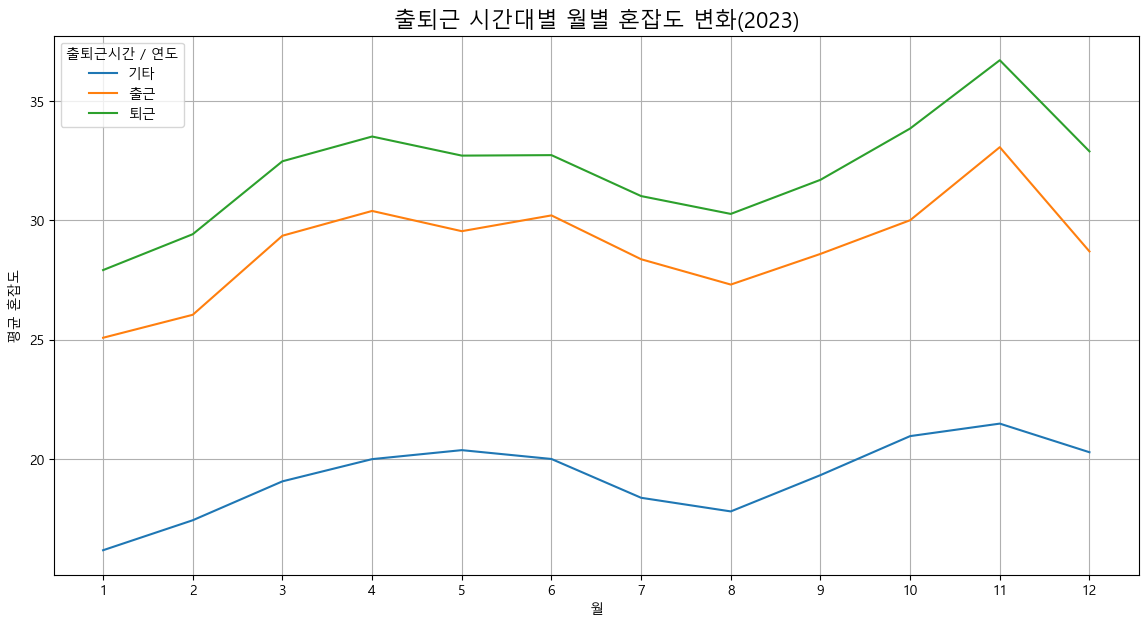

In [71]:
monthly_trend = df.groupby(['month', '출퇴근시간'])['congestion'].mean().reset_index()


plt.figure(figsize=(14, 7))
sns.lineplot(
    data=monthly_trend,
    x='month',
    y='congestion',
    hue='출퇴근시간',
    dashes=False
)
plt.title('출퇴근 시간대별 월별 혼잡도 변화(2023)', fontsize=16)
plt.xlabel('월')
plt.ylabel('평균 혼잡도')
plt.xticks(range(1, 13))
plt.legend(title='출퇴근시간 / 연도')
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

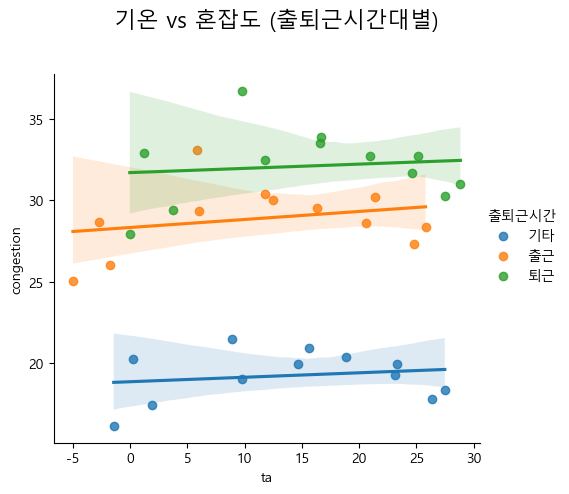

In [72]:
weather_grouped = df.groupby(['month', '출퇴근시간']).agg({
    'congestion': 'mean',
    'ta': 'mean',          # 실제 기온
    'chi': 'mean',      # 체감온도
    'rn_day': 'mean',      # 일 누적 강수량
}).reset_index()

plt.figure(figsize=(12, 6))
sns.lmplot(
    data=weather_grouped,
    x='ta', y='congestion',
    hue='출퇴근시간',
    height=5, aspect=1
)
plt.subplots_adjust(top=0.85)
plt.suptitle('기온 vs 혼잡도 (출퇴근시간대별)', fontsize=16)
plt.show()

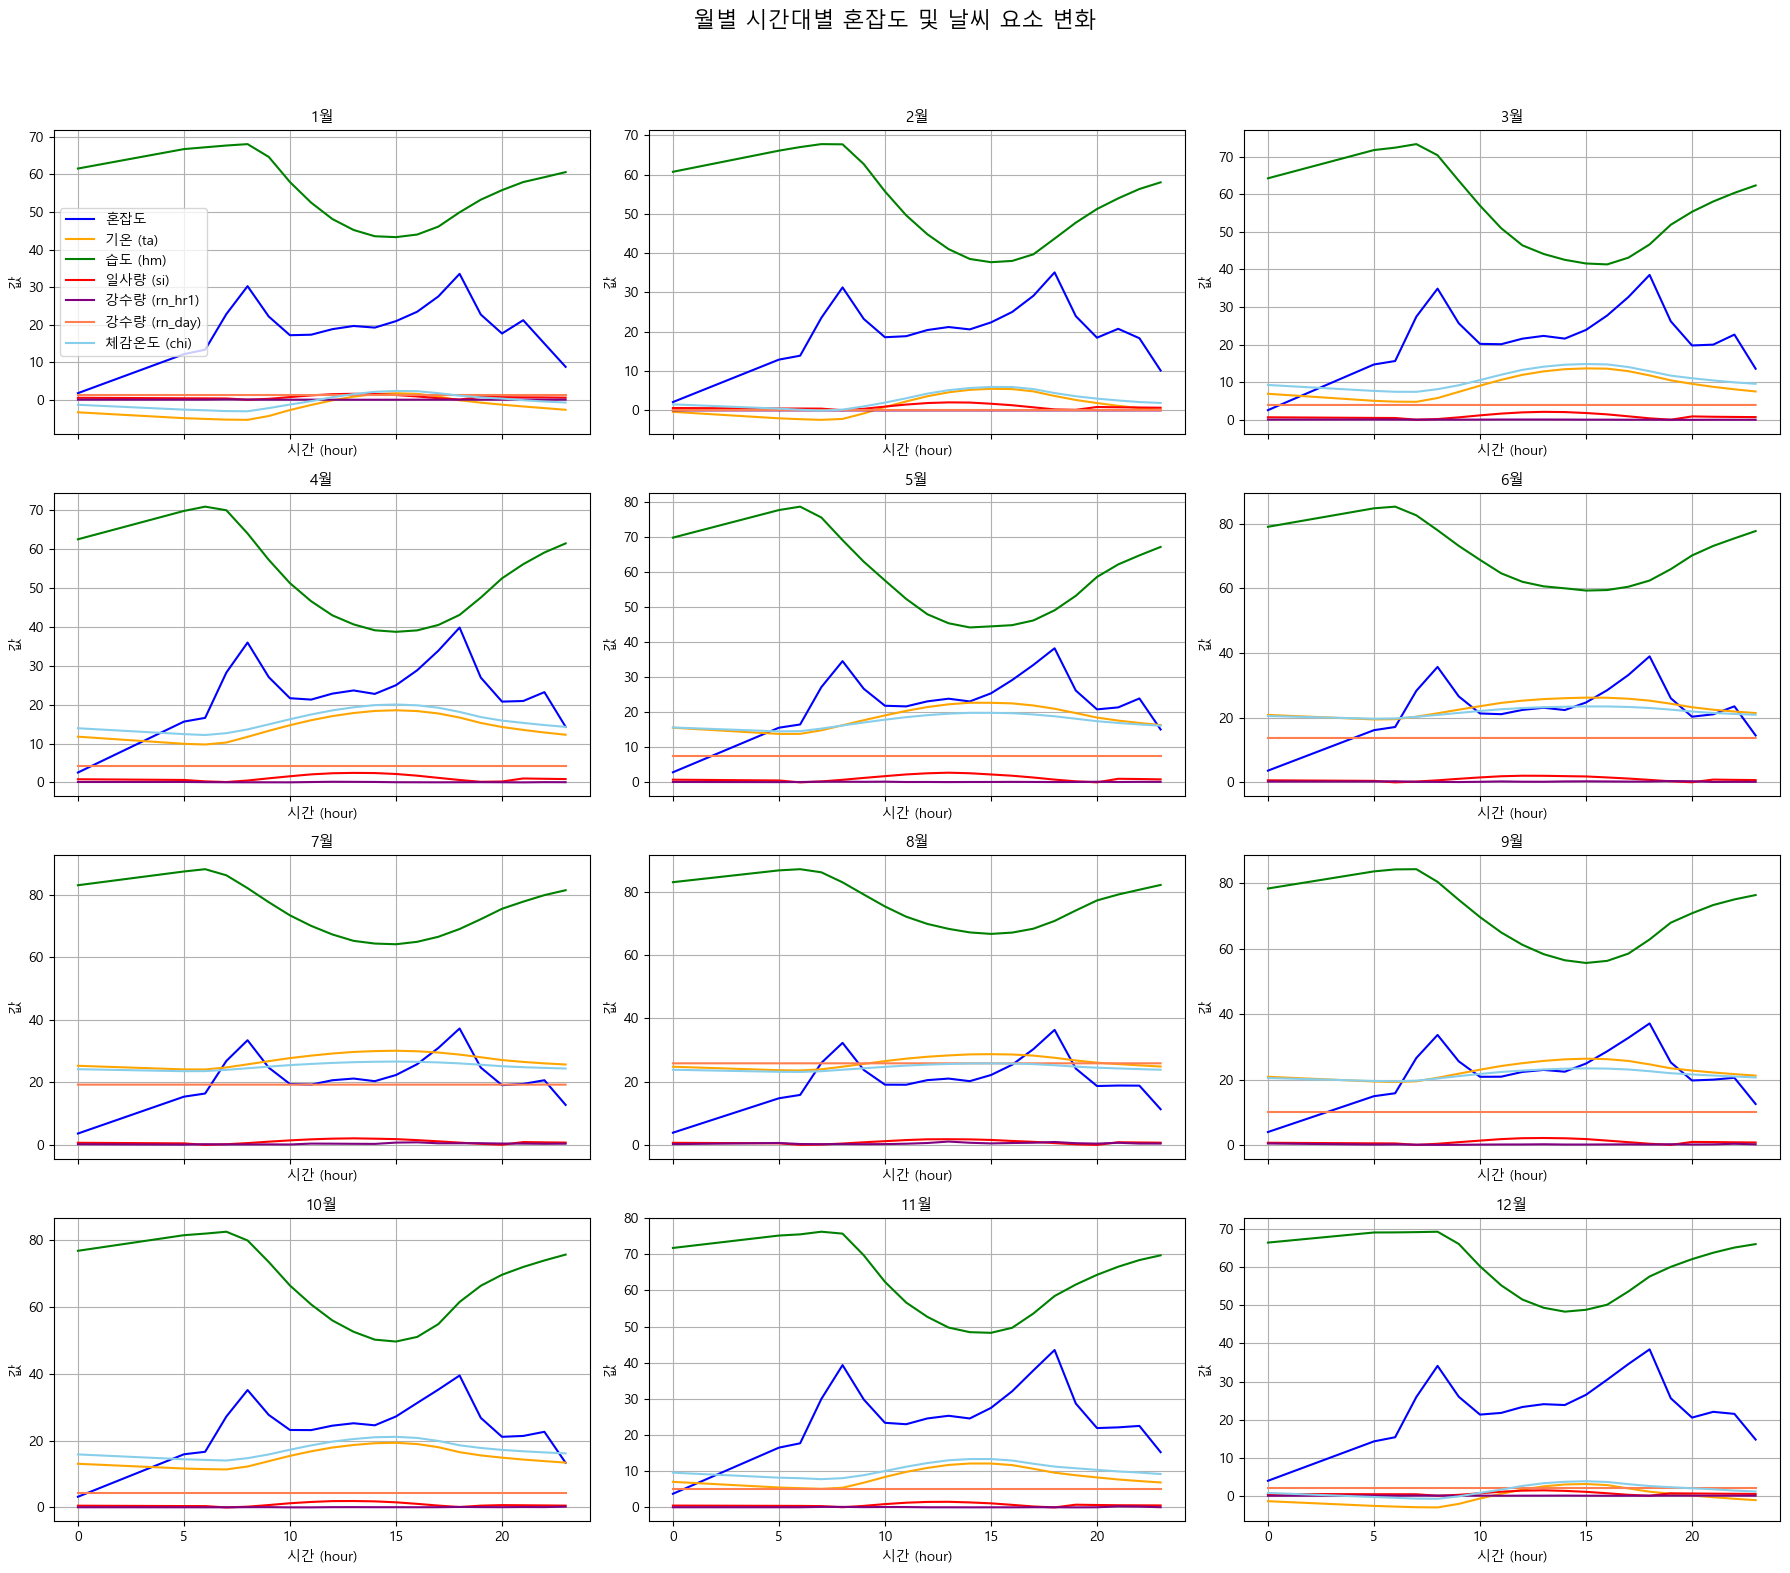

In [73]:
grouped = df.groupby(['month', 'hour'])[
    ['congestion', 'ta', 'hm', 'si', 'rn_hr1', 'rn_day', 'chi']
].mean().reset_index()

# unique한 (year, month) 조합 정렬
time_keys = sorted(grouped['month'].drop_duplicates().values.tolist())

# subplot 그리드 사이즈 설정 (예: 4행 x 3열)
ncols = 3
nrows = (len(time_keys) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, nrows * 4), sharex=True, sharey=False)
axes = axes.flatten()

# 각 (year, month)에 대해 하나의 subplot 생성
for i, month in enumerate(time_keys):
    ax = axes[i]
    df_sub = grouped[grouped['month'] == month]

    ax.plot(df_sub['hour'], df_sub['congestion'], color='blue', label='혼잡도')
    ax.plot(df_sub['hour'], df_sub['ta'], color='orange', label='기온 (ta)')
    ax.plot(df_sub['hour'], df_sub['hm'], color='green', label='습도 (hm)')
    ax.plot(df_sub['hour'], df_sub['si'], color='red', label='일사량 (si)')
    ax.plot(df_sub['hour'], df_sub['rn_hr1'], color='purple', label='강수량 (rn_hr1)')
    ax.plot(df_sub['hour'], df_sub['rn_day'], color='coral', label='강수량 (rn_day)')
    ax.plot(df_sub['hour'], df_sub['chi'], color='skyblue', label='체감온도 (chi)')

    ax.set_title(f'{month}월', fontsize=11)
    ax.set_xlabel('시간 (hour)')
    ax.set_ylabel('값')
    ax.grid(True)
    if i == 0:
        ax.legend()

# 남는 subplot은 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("월별 시간대별 혼잡도 및 날씨 요소 변화", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

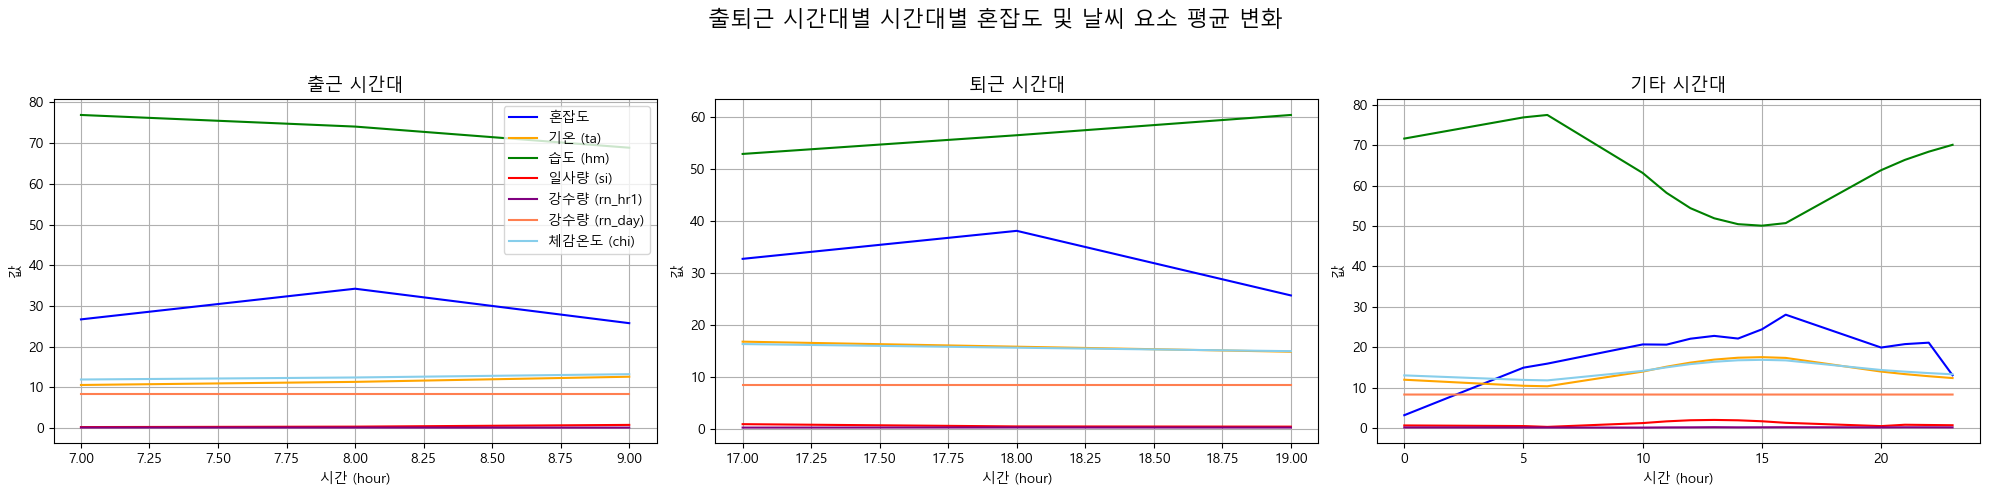

In [74]:
# 1. 출퇴근시간별로 groupby
grouped_by_commute = df.groupby(['출퇴근시간', 'hour'])[
    ['congestion', 'ta', 'hm', 'si', 'rn_hr1', 'rn_day', 'chi']
].mean().reset_index()

# 2. subplot 준비 (출근, 퇴근, 기타 총 3개)
commute_categories = ['출근', '퇴근', '기타']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharey=False)

# 3. 카테고리별 subplot 그리기
for i, category in enumerate(commute_categories):
    ax = axes[i]
    df_sub = grouped_by_commute[grouped_by_commute['출퇴근시간'] == category]

    ax.plot(df_sub['hour'], df_sub['congestion'], label='혼잡도', color='blue')
    ax.plot(df_sub['hour'], df_sub['ta'], label='기온 (ta)', color='orange')
    ax.plot(df_sub['hour'], df_sub['hm'], label='습도 (hm)', color='green')
    ax.plot(df_sub['hour'], df_sub['si'], label='일사량 (si)', color='red')
    ax.plot(df_sub['hour'], df_sub['rn_hr1'], label='강수량 (rn_hr1)', color='purple')
    ax.plot(df_sub['hour'], df_sub['rn_day'], label='강수량 (rn_day)', color='coral')
    ax.plot(df_sub['hour'], df_sub['chi'], label='체감온도 (chi)', color='skyblue')

    ax.set_title(f'{category} 시간대', fontsize=13)
    ax.set_xlabel('시간 (hour)')
    ax.set_ylabel('값')
    ax.grid(True)
    if i == 0:
        ax.legend(loc='upper right')

# 전체 타이틀과 레이아웃 조정
plt.suptitle('출퇴근 시간대별 시간대별 혼잡도 및 날씨 요소 평균 변화', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

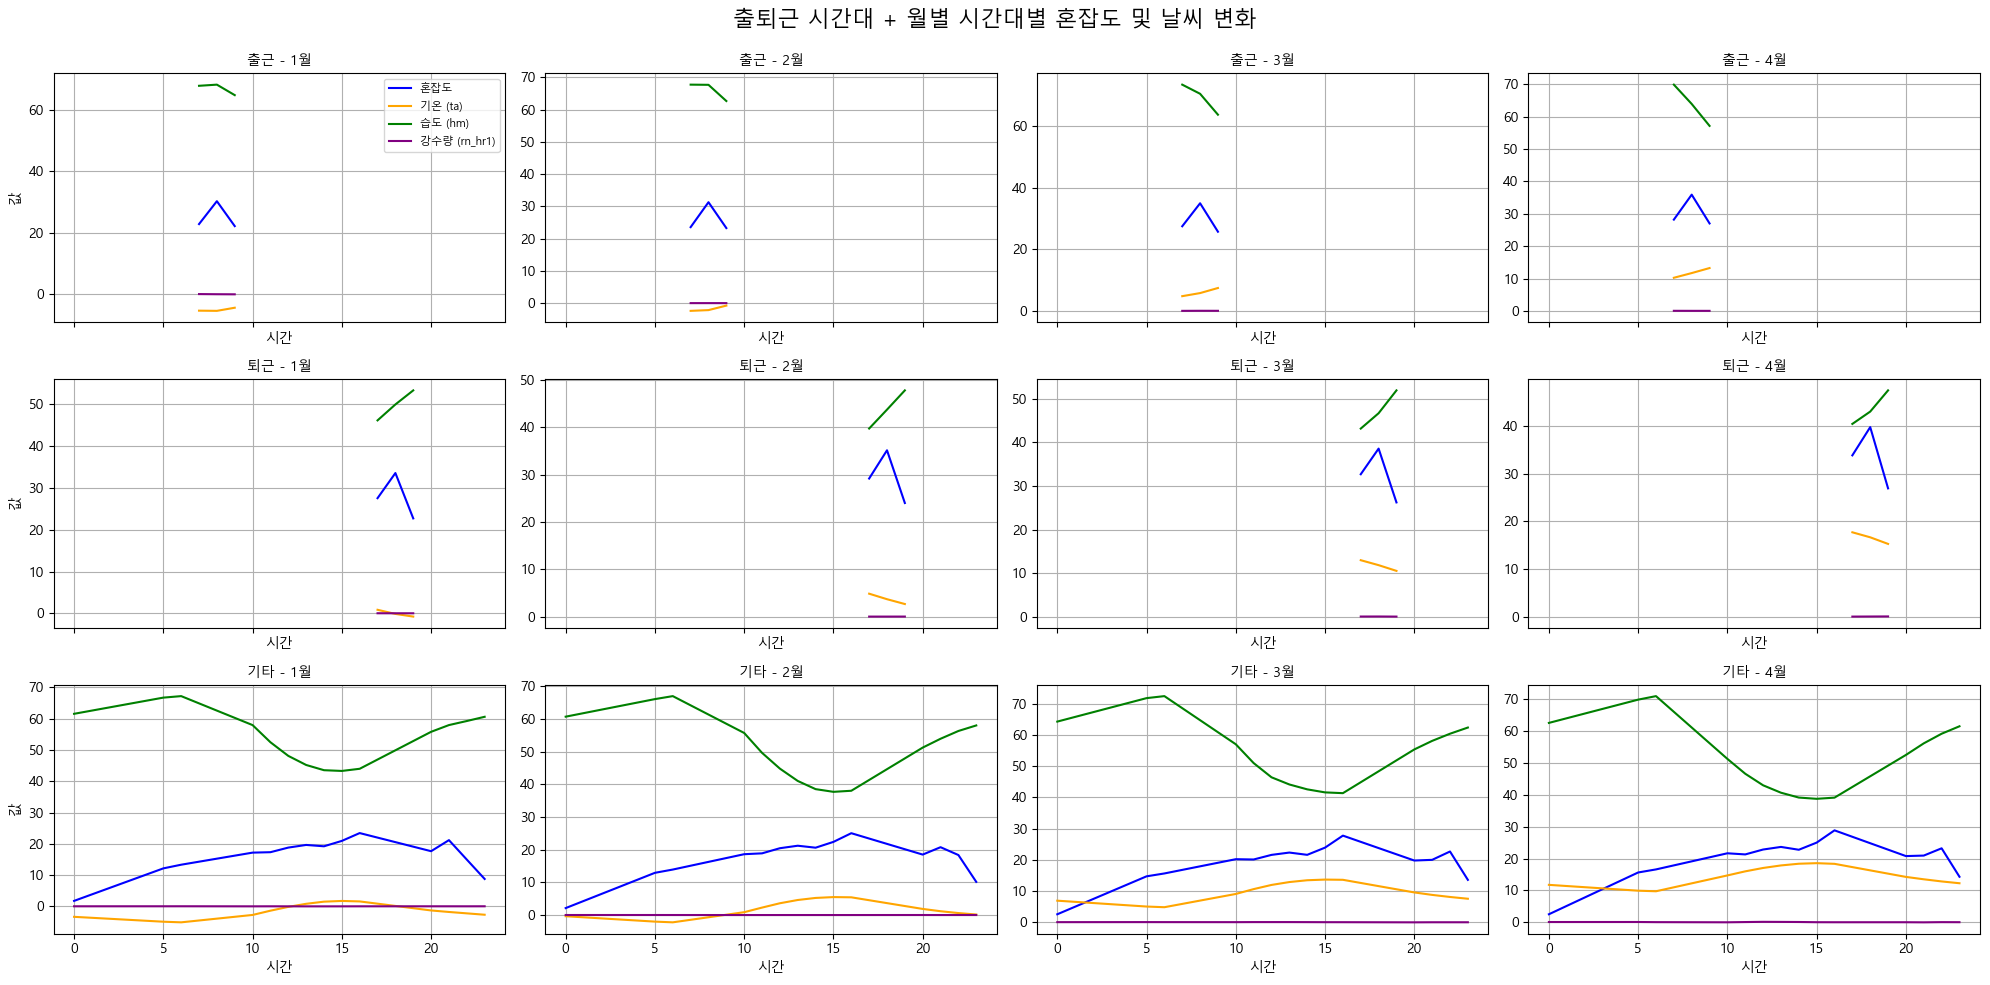

In [75]:
# 1. groupby로 평균 구하기
grouped = df.groupby(['출퇴근시간', 'month', 'hour'])[
    ['congestion', 'ta', 'hm', 'si', 'rn_hr1', 'rn_day', 'chi']
].mean().reset_index()

# 2. 카테고리와 월 리스트 정의
commute_categories = ['출근', '퇴근', '기타']
months = list(range(1, 13))

# 3. subplot 설정
nrows = 3  # 출퇴근시간 3개
ncols = 4  # 월 4개씩
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10), sharex=True, sharey=False)
axes = axes.reshape(nrows, ncols)

# 4. 반복해서 subplot 그리기
for i, commute in enumerate(commute_categories):
    for j, month in enumerate(months[:4]):  # 1~4월 먼저
        ax = axes[i, j]
        df_sub = grouped[(grouped['출퇴근시간'] == commute) & (grouped['month'] == month)]

        ax.plot(df_sub['hour'], df_sub['congestion'], label='혼잡도', color='blue')
        ax.plot(df_sub['hour'], df_sub['ta'], label='기온 (ta)', color='orange')
        ax.plot(df_sub['hour'], df_sub['hm'], label='습도 (hm)', color='green')
        ax.plot(df_sub['hour'], df_sub['rn_hr1'], label='강수량 (rn_hr1)', color='purple')

        ax.set_title(f'{commute} - {month}월', fontsize=10)
        ax.set_xlabel('시간')
        if j == 0:
            ax.set_ylabel('값')

        ax.grid(True)
        if i == 0 and j == 0:
            ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('출퇴근 시간대 + 월별 시간대별 혼잡도 및 날씨 변화', fontsize=16)
plt.show()


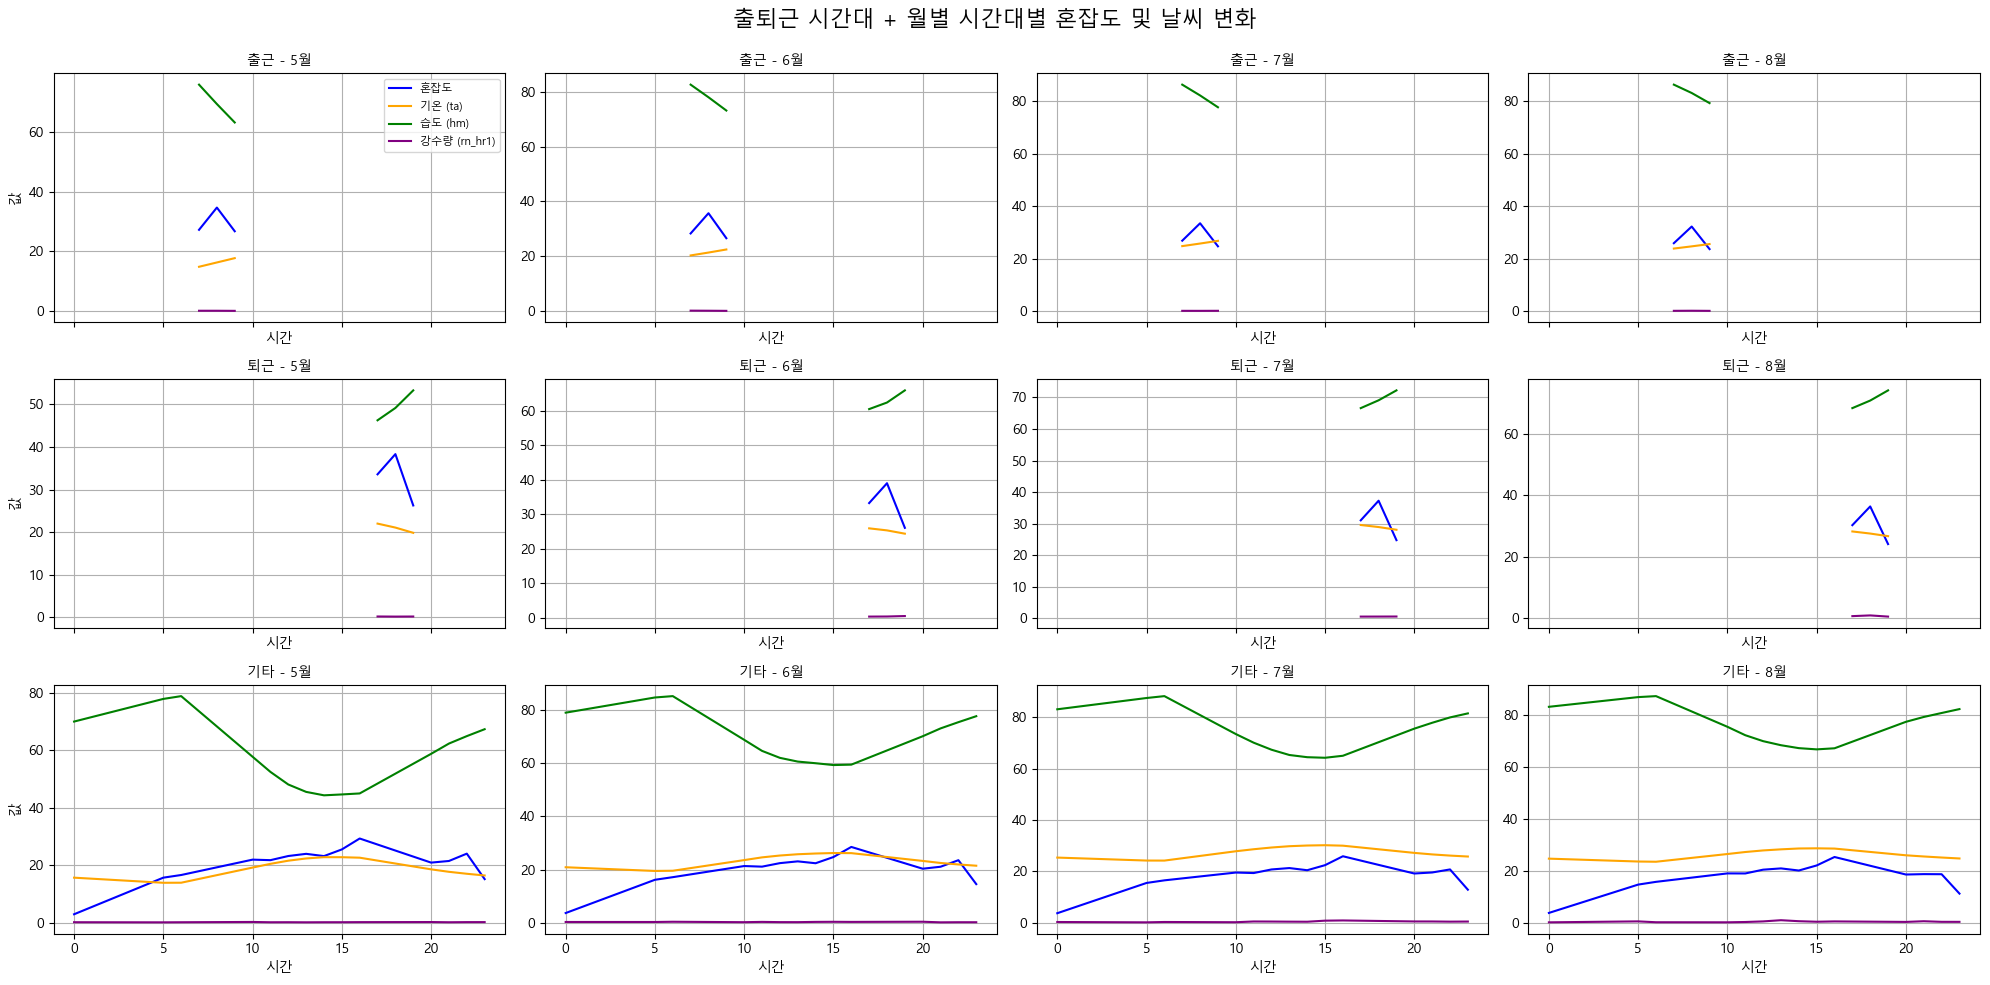

In [76]:
# 1. groupby로 평균 구하기
grouped = df.groupby(['출퇴근시간', 'month', 'hour'])[
    ['congestion', 'ta', 'hm', 'si', 'rn_hr1', 'rn_day', 'chi']
].mean().reset_index()

# 2. 카테고리와 월 리스트 정의
commute_categories = ['출근', '퇴근', '기타']
months = list(range(1, 13))

# 3. subplot 설정
nrows = 3  # 출퇴근시간 3개
ncols = 4  # 월 4개씩
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10), sharex=True, sharey=False)
axes = axes.reshape(nrows, ncols)

# 4. 반복해서 subplot 그리기
for i, commute in enumerate(commute_categories):
    for j, month in enumerate(months[4:8]):  # 5-8월
        ax = axes[i, j]
        df_sub = grouped[(grouped['출퇴근시간'] == commute) & (grouped['month'] == month)]

        ax.plot(df_sub['hour'], df_sub['congestion'], label='혼잡도', color='blue')
        ax.plot(df_sub['hour'], df_sub['ta'], label='기온 (ta)', color='orange')
        ax.plot(df_sub['hour'], df_sub['hm'], label='습도 (hm)', color='green')
        ax.plot(df_sub['hour'], df_sub['rn_hr1'], label='강수량 (rn_hr1)', color='purple')

        ax.set_title(f'{commute} - {month}월', fontsize=10)
        ax.set_xlabel('시간')
        if j == 0:
            ax.set_ylabel('값')

        ax.grid(True)
        if i == 0 and j == 0:
            ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('출퇴근 시간대 + 월별 시간대별 혼잡도 및 날씨 변화', fontsize=16)
plt.show()


In [77]:
from scipy.stats import f_oneway

# 각 그룹의 혼잡도 추출
congestion_go = df[df['출퇴근시간'] == '출근']['congestion']
congestion_off = df[df['출퇴근시간'] == '퇴근']['congestion']
congestion_else = df[df['출퇴근시간'] == '기타']['congestion']

# 일원분산분석 (ANOVA)
f_stat, p_value = f_oneway(congestion_go, congestion_off, congestion_else)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")

if p_value < 0.05:
    print("✅ 출퇴근시간에 따라 혼잡도의 유의미한 차이가 있습니다.")
else:
    print("❌ 출퇴근시간에 따른 혼잡도 차이는 통계적으로 유의하지 않습니다.")

F-statistic: 619295.3779
P-value: 0.0000e+00
✅ 출퇴근시간에 따라 혼잡도의 유의미한 차이가 있습니다.


🎯 분석 개요
- 출퇴근 시간대에 따라 지하철 혼잡도(congestion)가 유의미하게 차이가 있는지를 검정하기 위해 일원분산분석(ANOVA)를 수행. 이 분석은 다음 세 그룹 간 평균 혼잡도 차이를 비교
    - 출근 시간대 (예: 07~09시)
    - 퇴근 시간대 (예: 18~20시)
    - 기타 시간대 (그 외)
📊 결과 요약
- F-statistic: 619,295.3779
- P-value: 0.0000e+00 (즉, 거의 0)
✅ 해석
- 🔍 F-statistic: 619,295.3779
    - F값이 매우 크다는 것은 세 그룹 간의 분산(평균의 차이)이 그룹 내의 분산보다 매우 크다는 것을 의미
    - 즉, 단순한 우연이나 내부 변동성으로는 설명되지 않을 정도로 출근/퇴근/기타 시간대 혼잡도 평균이 다르다는 뜻임

- 🔬 P-value: 0.0000
    - p-value가 0.05보다 훨씬 작고, 사실상 0에 수렴하므로, 귀무가설(모든 그룹의 평균이 같다)을 기각
    - 즉, 출근/퇴근/기타 시간대 간 혼잡도 평균이 유의미하게 다르다는 강력한 통계적 근거가 있음

In [78]:
from scipy.stats import ttest_ind

# 출근 vs 퇴근
t_stat, p_value = ttest_ind(congestion_go, congestion_off, equal_var=False)
print(f"[출근 vs 퇴근] P-value: {p_value:.4e}")

# 출근 vs 기타
t_stat, p_value = ttest_ind(congestion_go, congestion_else, equal_var=False)
print(f"[출근 vs 기타] P-value: {p_value:.4e}")

# 퇴근 vs 기타
t_stat, p_value = ttest_ind(congestion_off, congestion_else, equal_var=False)
print(f"[퇴근 vs 기타] P-value: {p_value:.4e}")

[출근 vs 퇴근] P-value: 0.0000e+00
[출근 vs 기타] P-value: 0.0000e+00
[퇴근 vs 기타] P-value: 0.0000e+00


## 상선 vs 하선

In [79]:
# 각 호선별 상선/하선에 따른 혼잡도 및 불쾌지수 통계량 계산
direction_analysis = df.groupby(['line', 'direction']).agg(
    mean_congestion=('congestion', 'mean'),
    median_congestion=('congestion', 'median'),
    max_congestion=('congestion', 'max'),
    mean_discomfort_index=('discomfort_index', 'mean'),
    median_discomfort_index=('discomfort_index', 'median'),
    max_discomfort_index=('discomfort_index', 'max')
).reset_index()

# 결과 출력
print("--- 각 호선별 상선/하선 혼잡도 및 불쾌지수 분석 결과 ---")
print(direction_analysis)

# 특정 호선에 대한 상세 분석 예시 (예: 7호선)
print("\n--- 7호선 상선/하선 분석 결과 ---")
print(direction_analysis[direction_analysis['line'] == 7])

--- 각 호선별 상선/하선 혼잡도 및 불쾌지수 분석 결과 ---
    line direction  mean_congestion  median_congestion  max_congestion  \
0      1        상선        19.652837               16.0             231   
1      1        하선        19.689643               16.0             230   
2      2        내선        30.999152               28.0             159   
3      2        외선        31.389910               29.0             167   
4      3        상선        21.542479               17.0             289   
5      3        하선        21.576693               17.0             242   
6      4        상선        21.817668               18.0             156   
7      4        하선        20.240102               17.0             176   
8      5        상선        22.802003               19.0             152   
9      5        하선        22.630041               20.0             146   
10     6        상선        16.171612               14.0             173   
11     6        하선        17.232353               15.0             198   
1

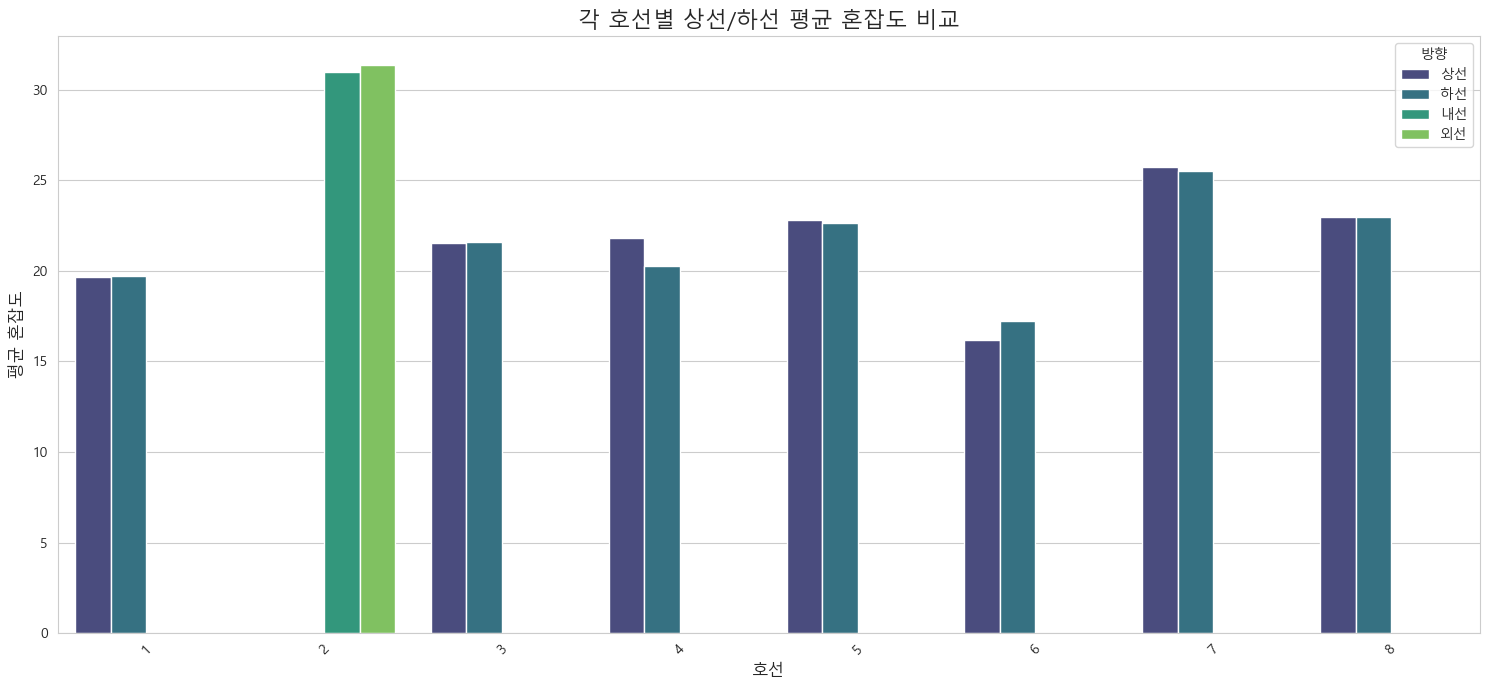

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# 이전 단계에서 생성된 direction_analysis 데이터프레임이 있다고 가정합니다.
# 만약 direction_analysis가 없다면, 아래 코드를 다시 실행하여 생성해주세요.
# direction_analysis = df_1.groupby(['line', 'direction']).agg(
#     mean_congestion=('congestion', 'mean'),
#     mean_discomfort_index=('discomfort_index', 'mean')
# ).reset_index()

# 그래프 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트 설정 (Windows 기준)
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 각 호선별 상선/하선 평균 혼잡도 시각화
plt.figure(figsize=(15, 7))
sns.barplot(data=direction_analysis, x='line', y='mean_congestion', hue='direction', palette='viridis')
plt.title('각 호선별 상선/하선 평균 혼잡도 비교', fontsize=16)
plt.xlabel('호선', fontsize=12)
plt.ylabel('평균 혼잡도', fontsize=12)
plt.xticks(rotation=45) # 호선 이름이 겹치지 않도록 회전
plt.legend(title='방향')
plt.tight_layout() # 그래프 요소들이 겹치지 않도록 자동 조정
plt.show()

## 2021 - 2022 제거

- 2021년과 2022년도에 코로나 바이러스로 인한 거리두기 정책으로 인해 향후 모델링에 있어 불필요한 요소가 들어갈 가능성이 있기 때문에 제거를 해 준다.

In [81]:
# 연도 추출하여 필터링
df_1 = df[~df['date_dt'].dt.year.isin([2021, 2022])]

# 상관 분석을 통한 피처 선택

| 분석 목적                          | 사용할 분석 방법                                        | 설명                       |
| ------------------------------- | ------------------------------------------------ | ------------------------ |
| **혼잡도와 어떤 변수들이 관련 있는지 확인하고 싶다** | `Pearson` 또는 `Spearman` 상관계수                     | 선형/비선형 **상관 관계만** 판단     |
| **혼잡도에 영향을 주는 요인을 해석하고 싶다**     | `Poisson 회귀`                                     | 통계적 **유의성 + 인과 해석** 가능   |
| **혼잡도를 예측하고 싶다 (정확하게 예측값 뽑기)**  | 💡 머신러닝 모델 (예: Random Forest, XGBoost, LightGBM) | 예측 정확도에 집중, **설명력은 떨어짐** |


In [82]:
# 필요한 수치형 변수들만 추려서 확인
numerical_cols = ['ta', 'wd', 'ws', 'rn_hr1', 'hm', 'si', 'chi', 'discomfort_index', 'rn_day', 'hour', 'congestion']
df_corr = df_1[numerical_cols]

# 상관계수 계산
pearson_corr = df_corr.corr(method='pearson')
spearman_corr = df_corr.corr(method='spearman')


MemoryError: 

c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


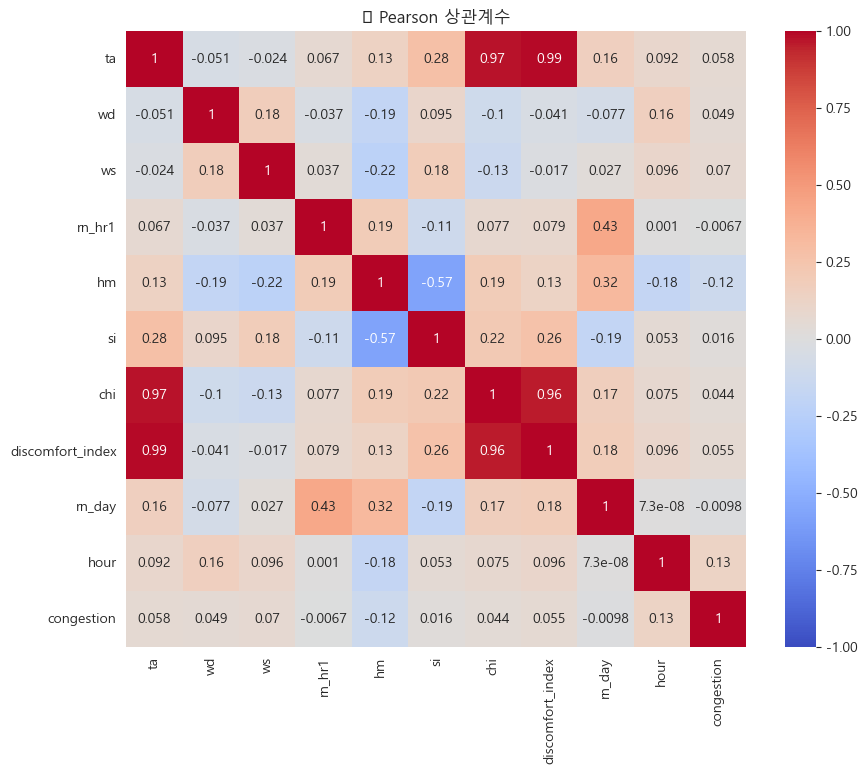

c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


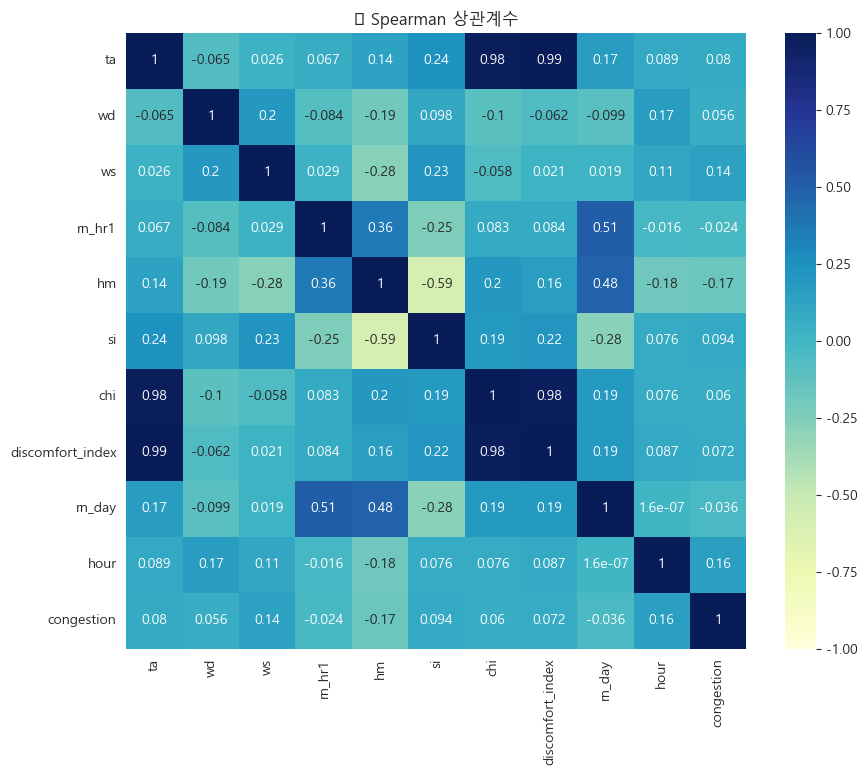

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pearson 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("📊 Pearson 상관계수")
plt.show()

# Spearman 히트맵 (선택)
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='YlGnBu', vmin=-1, vmax=1)
plt.title("📊 Spearman 상관계수")
plt.show()

- 1. 피어슨 상관계수
    - 변수 간 선형 관계를 측정합니다.
    - ta, chi, discomfort_index가 타겟(congestion)과 약 0.05~0.06 정도의 약한 양의 상관을 보이고 있습니다.
    - hour는 약 0.13 정도로 상대적으로 높은 상관을 나타냅니다.
    - 일부 변수는 음의 상관도 보입니다(hm 등).
- 2. 스피어만 상관계수
    - 변수 간 순위 기반(비선형 포함) 관계를 측정합니다.
    - ta, chi, discomfort_index가 타겟과 약 0.06~0.07 정도로 피어슨보다 약간 더 높은 상관을 보입니다.
    - hour도 약 0.16으로 피어슨보다 더 높은 상관을 나타냅니다.
    - rn_hr1, hm 등 일부 변수는 피어슨과 다른 방향 또는 크기의 상관을 보입니다.

- 어떤 결과를 기준으로 피처를 선택할지?
    - 스피어만 상관계수 결과를 우선 고려하는 것을 추천.

        - 이유: 기상 및 혼잡도 데이터는 비선형적이고 이상치가 있을 가능성이 크므로, 순위 기반 상관인 스피어만이 더 현실적인 변수 관계를 반영할 수 있습니다.
        - 또한, 스피어만 상관계수에서 타겟과 상대적으로 높은 상관을 보이는 변수(hour, ta, chi, discomfort_index)를 우선 선택하는 것이 좋습니다.
        - 피어슨 상관계수도 참고하여, 두 지표 모두에서 상관이 높은 변수는 더욱 신뢰할 수 있습니다.

|변수명	|피어슨 상관계수 (congestion)	|스피어만 상관계수 (congestion)	|선택 여부 추천|
|----|-----|-----|----|
|hour|	0.13|	0.16|	선택|
|ta|	0.058|	0.08|	선택|
|chi|	0.044|	0.06|	선택|
|discomfort_index|	0.055|	0.072|	선택|
|rn_hr1|	0.001|	-0.024|	제외 가능|
|hm|	-0.12|	-0.17|	제외 가능|
|wd|	0.049|	0.056|	선택 고려|
|ws|	0.07|	0.14|	선택 고려|
|rn_day|	-0.009|	-0.036|	제외 가능|
|si|	0.016|	0.094|	선택 고려|

- 상관관계가 낮다고 무조건 제외하지 말고, 모델 성능 평가를 통해 최종 판단. 특히 풍속(ws)과 풍향(wd)은 다른 변수와 상호작용할 가능성도 있으니, 모델에 넣고 중요도 확인.
- 다중공선성 문제도 반드시 확인. 예를 들어 ta, chi, discomfort_index는 서로 매우 높은 상관관계를 가지므로, VIF 검사 후 일부 변수를 제거하거나 조합하는 것이 필요.
- 모델 성능과 해석 용이성을 고려해 변수 수를 조절.

# 군집 분석

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19448\963786267.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['is_high_discomfort'] = df_1['di_level'].isin(['불쾌', '매우 불쾌']).astype(int)


--- df_1 데이터프레임의 상위 5개 행 (확인용) ---
                date  line  station_number station_name direction  stn   ta  \
10331755  2023010100     1             150          서울역        상선  419  0.3   
10331756  2023010105     1             150          서울역        상선  419 -0.8   
10331757  2023010106     1             150          서울역        상선  419 -1.8   
10331758  2023010107     1             150          서울역        상선  419 -2.6   
10331759  2023010108     1             150          서울역        상선  419 -3.0   

             wd   ws  rn_hr1  ...  is_weekend_or_holiday  month  is_same  \
10331755  318.0  3.4     0.0  ...                      1      1    False   
10331756   29.6  3.7     0.0  ...                      1      1    False   
10331757   48.1  3.4     0.0  ...                      1      1    False   
10331758   21.4  2.9     0.0  ...                      1      1    False   
10331759  353.4  2.8     0.0  ...                      1      1    False   

          discomfort_index  di_le

c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarn

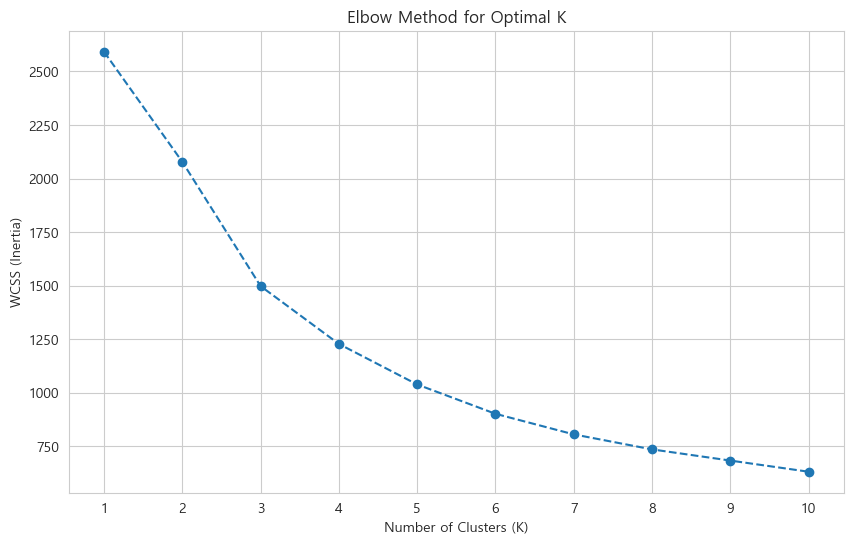

엘보우 그래프를 통해 WCSS 감소율이 급격히 줄어드는 지점을 최적의 K로 선택합니다.

--- K-means 클러스터링을 시작합니다. 최적의 K 값: 3 ---
--- K-means 클러스터링 결과 (K=3) - 상위 5개 역 ---
  station_name  cluster_label
0           가능              0
1         가락시장              1
2      가산디지털단지              1
3           간석              0
4           강남              1


--- 각 클러스터의 평균 특성 (스케일링되지 않은 원본 값) ---
               mean_congestion  max_congestion  mean_discomfort_index  \
cluster_label                                                           
0                    14.807946          57.128              57.493772   
1                    33.353439         119.000              58.478380   
2                     5.763542          74.000              27.118209   

               prop_high_discomfort    mean_ta    mean_hm   mean_ws  \
cluster_label                                                         
0                          0.049249  13.924248  66.224880  1.486053   
1                          0.051483  14.526342  62.392319  1.708383 

c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


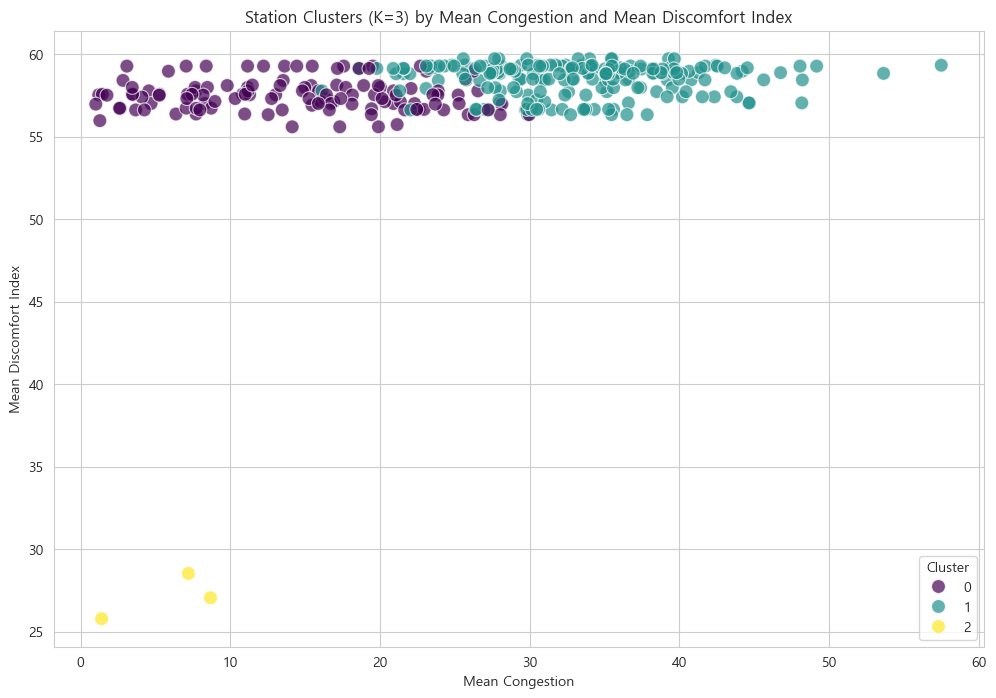

--- 각 클러스터에 속하는 역 이름 (상위 10개) ---

클러스터 0:
['가능', '간석', '강일', '개화산', '경찰병원', '고잔', '공릉', '광운대', '구산', '구파발']
------------------------------

클러스터 1:
['가락시장', '가산디지털단지', '강남', '강남구청', '강동', '강동구청', '강변', '개봉', '건대입구', '경마공원']
------------------------------

클러스터 2:
['연천', '전곡', '청산']
------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

if 'is_high_discomfort' not in df_1.columns:
    df_1['is_high_discomfort'] = df_1['di_level'].isin(['불쾌', '매우 불쾌']).astype(int)

print("--- df_1 데이터프레임의 상위 5개 행 (확인용) ---")
print(df_1.head())
print("\n")

### 1. 데이터 준비 및 집계
# 역 별 특성을 나타내는 피처를 정의하고 집계합니다.
# 각 컬럼의 평균을 계산할 때 numeric_only=True를 명시적으로 적용합니다.
station_features = df_1.groupby('station_name').agg(
    mean_congestion=('congestion', lambda x: x.mean(numeric_only=True)),
    max_congestion=('congestion', 'max'),
    mean_discomfort_index=('discomfort_index', lambda x: x.mean(numeric_only=True)),
    prop_high_discomfort=('is_high_discomfort', lambda x: x.mean(numeric_only=True)), # 높은 불쾌지수 발생 비율
    mean_ta=('ta', lambda x: x.mean(numeric_only=True)),
    mean_hm=('hm', lambda x: x.mean(numeric_only=True)),
    mean_ws=('ws', lambda x: x.mean(numeric_only=True)),
    total_rn_day=('rn_day', 'sum') # sum()은 숫자형이 아닌 값을 자동으로 무시하므로 변경 불필요
).reset_index()

print("--- 역 별 집계된 피처 데이터 (상위 5개 행) ---")
print(station_features.head())
print("\n")

# 클러스터링에 사용할 피처 선택 (station_name 컬럼 제외)
features_for_clustering = station_features.drop(columns=['station_name'])

### 2. 피처 스케일링
# StandardScaler를 사용하여 피처들을 표준화합니다.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)
scaled_features_df = pd.DataFrame(scaled_features, columns=features_for_clustering.columns)

print("--- 스케일링된 피처 데이터 (상위 5개 행) ---")
print(scaled_features_df.head())
print("\n")

### 3. 최적의 클러스터 개수(K) 결정 (엘보우 방법)
# WCSS (Within-Cluster Sum of Squares) 또는 Inertia를 계산하여 엘보우 포인트를 찾습니다.
wcss = []
# 클러스터 개수 1부터 10까지 시도 (필요에 따라 범위 조정 가능)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11)) # x축 눈금을 1부터 10까지 표시
plt.grid(True)
plt.show()
print("엘보우 그래프를 통해 WCSS 감소율이 급격히 줄어드는 지점을 최적의 K로 선택합니다.\n")

### 4. K-means 클러스터링 적용
# 엘보우 방법을 통해 결정된 최적의 K 값을 사용합니다.
# 아래 optimal_k 값은 엘보우 그래프를 보고 채소리1님께서 직접 결정해야 합니다.
# 예시로 3을 사용하지만, 실제 그래프를 보고 가장 적절한 값을 선택하십시오.
optimal_k = 3

print(f"--- K-means 클러스터링을 시작합니다. 최적의 K 값: {optimal_k} ---")
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# 원본 역 피처 데이터에 클러스터 라벨 추가
station_features['cluster_label'] = cluster_labels

print(f"--- K-means 클러스터링 결과 (K={optimal_k}) - 상위 5개 역 ---")
print(station_features[['station_name', 'cluster_label']].head())
print("\n")

### 5. 군집 결과 해석 및 시각화

# 5.1. 각 군집의 평균 특성 분석
# 스케일링되지 않은 원본 피처를 사용하여 각 군집의 특성을 파악하는 것이 더 직관적입니다.
# station_name 컬럼을 제외하고 평균을 계산합니다.
cluster_summary = station_features.drop(columns=['station_name']).groupby('cluster_label').mean()
print("--- 각 클러스터의 평균 특성 (스케일링되지 않은 원본 값) ---")
print(cluster_summary)
print("\n")

# 5.2. 각 클러스터에 속한 역의 개수 확인
print("--- 각 클러스터에 속한 역의 개수 ---")
print(station_features['cluster_label'].value_counts().sort_index())
print("\n")

# 5.3. 시각화를 통해 군집 특성 파악
# 두 가지 주요 피처를 기준으로 클러스터링 결과 시각화
# 예: 'mean_congestion'과 'mean_discomfort_index'를 사용하여 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=station_features, x='mean_congestion', y='mean_discomfort_index',
                hue='cluster_label', palette='viridis', s=100, alpha=0.7)
plt.title(f'Station Clusters (K={optimal_k}) by Mean Congestion and Mean Discomfort Index')
plt.xlabel('Mean Congestion')
plt.ylabel('Mean Discomfort Index')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

# 5.4. 각 클러스터에 속하는 역 이름 확인 (일부)
print("--- 각 클러스터에 속하는 역 이름 (상위 10개) ---")
for i in range(optimal_k):
    print(f"\n클러스터 {i}:")
    # 해당 클러스터에 속하는 역이 없을 경우를 대비하여 조건문 추가
    if not station_features[station_features['cluster_label'] == i].empty:
        print(station_features[station_features['cluster_label'] == i]['station_name'].head(10).tolist())
    else:
        print("해당 클러스터에 속하는 역이 없습니다.")
    print("-" * 30)


- 1. 클러스터 개수 및 분포
    - 최적의 클러스터 개수는 3개로 선정하셨고, 각 클러스터별 역 개수는 다음과 같습니다.
        - 클러스터 0: 125개 역
        - 클러스터 1: 196개 역
        - 클러스터 2: 3개 역 (매우 소수)

- 2. 클러스터별 특성 비교

|클러스터	|평균 혼잡도 (mean_congestion)	|최대 혼잡도 (max_congestion)	|평균 불쾌지수 (mean_discomfort_index)	|높은 불쾌지수 비율 (prop_high_discomfort)	|평균 기온 (mean_ta)	|평균 습도 (mean_hm)	|평균 풍속 (mean_ws)	|총 강수량 (total_rn_day)|
|----|----|----|----|---|---|---|---|----|
|0	|14.81	|57.13	|57.49	|0.049	|13.92	|66.22	|1.49	|101,710|
|1	|33.35	|119.00	|58.48	|0.051	|14.53	|62.39	|1.71	|154,151|
|2	|5.76	|74.00	|27.12	|0.000	|-5.86	|73.27	|0.99	|892|


- 3. 시각화 해석
    - 산점도 그래프에서 클러스터 0과 1은 불쾌지수(세로축)가 비슷한 수준으로 높게 분포하지만, 혼잡도(가로축)에서는 클러스터 1이 훨씬 높은 값을 보입니다.
    - 클러스터 2는 혼잡도와 불쾌지수 모두 낮은 영역에 위치해 있어, 다른 두 클러스터와 명확히 구분됩니다.
- 4. 종합 해석 및 활용 방안
    - 클러스터 1 (고혼잡·고불쾌지수 그룹): 서울 주요 중심지나 출퇴근 시간대 혼잡이 심한 역일 가능성이 높습니다. 이 그룹은 혼잡 완화 및 쾌적한 환경 조성을 위한 우선 관리 대상입니다.
    - 클러스터 0 (중간 혼잡·중간 불쾌지수 그룹): 혼잡도와 불쾌지수가 중간 수준인 역들로, 관리 우선순위는 클러스터 1보다는 낮으나 주기적인 모니터링이 필요합니다.
    - 클러스터 2 (저혼잡·저불쾌지수 그룹): 혼잡도가 낮고 쾌적한 환경을 가진 역들로, 상대적으로 관리 부담이 적을 것으로 예상됩니다. 다만 역 수가 적어 개별 역 특성을 면밀히 분석할 필요가 있습니다.

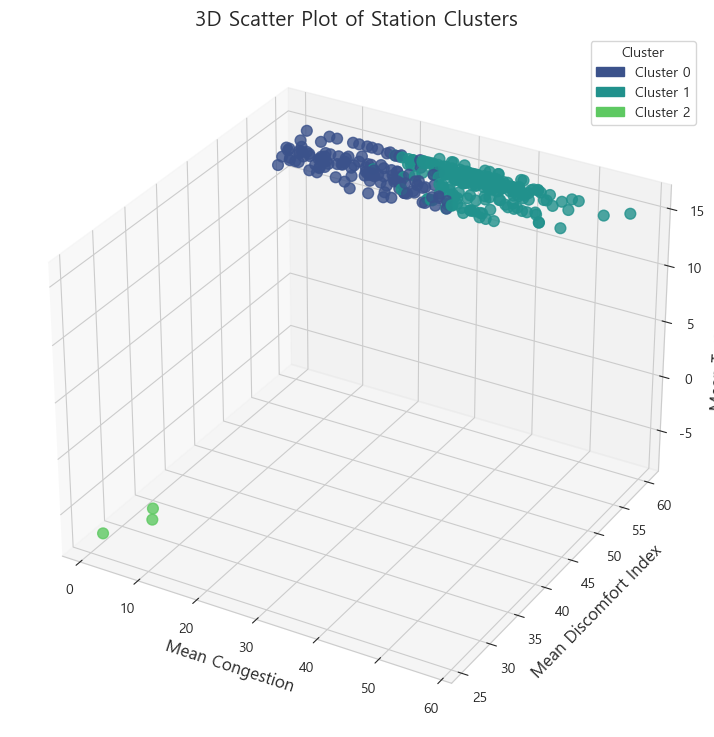

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D 플롯을 위한 모듈
import seaborn as sns

# 클러스터링 결과가 포함된 station_features 데이터프레임이 있다고 가정합니다.

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# x, y, z 축에 사용할 변수 지정
x = station_features['mean_congestion']
y = station_features['mean_discomfort_index']
z = station_features['mean_ta']

# 클러스터 라벨에 따라 색상 지정
clusters = station_features['cluster_label']
palette = sns.color_palette("viridis", n_colors=clusters.nunique())

# 클러스터별 색상 매핑
colors = [palette[label] for label in clusters]

# 3D 산점도 그리기
scatter = ax.scatter(x, y, z, c=colors, s=60, alpha=0.8)

# 축 라벨 설정
ax.set_xlabel('Mean Congestion', fontsize=12)
ax.set_ylabel('Mean Discomfort Index', fontsize=12)
ax.set_zlabel('Mean Temperature (Ta)', fontsize=12)

# 제목 설정
ax.set_title('3D Scatter Plot of Station Clusters', fontsize=15)

# 범례 생성
# 클러스터별 대표 색상과 이름을 범례로 표시
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=palette[i], label=f'Cluster {i}') for i in range(clusters.nunique())]
ax.legend(handles=legend_patches, title='Cluster')

plt.show()

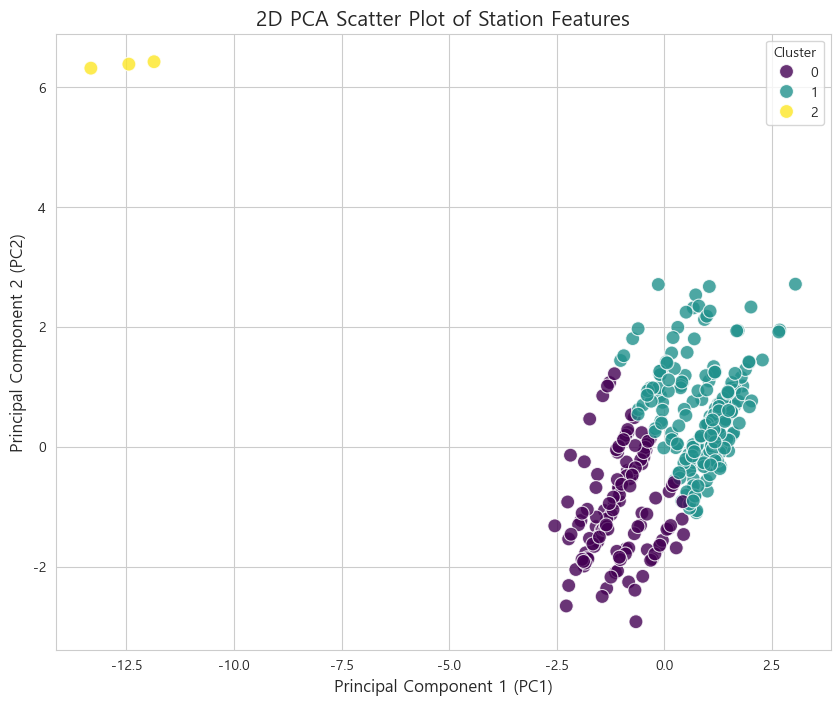

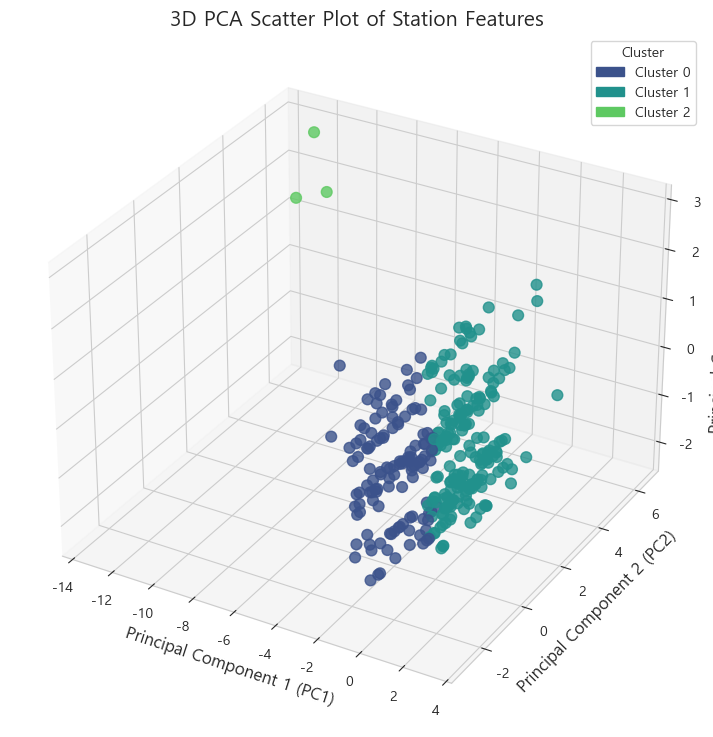

2D PCA 주성분별 분산 설명 비율
PC1: 34.47%
PC2: 20.55%
2D 누적 설명 비율: 55.02%

3D PCA 주성분별 분산 설명 비율
PC1: 34.47%
PC2: 20.55%
PC3: 15.97%
3D 누적 설명 비율: 70.98%



In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np

# 1. PCA 적용 (2차원)
pca = PCA(n_components=2)
principal_components_2d = pca.fit_transform(scaled_features)


pca_df_2d = pd.DataFrame(data=principal_components_2d, columns=['PC1', 'PC2'])
pca_df_2d['cluster_label'] = cluster_labels  

# 2차원 산점도 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df_2d, x='PC1', y='PC2', hue='cluster_label', palette='viridis', s=100, alpha=0.8)
plt.title('2D PCA Scatter Plot of Station Features', fontsize=15)
plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# PCA 적용 -> 3차원
pca_3d = PCA(n_components=3)
principal_components_3d = pca_3d.fit_transform(scaled_features)


pca_df_3d = pd.DataFrame(data=principal_components_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['cluster_label'] = cluster_labels 

# 3차원 산점도 시각화
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# 3D 산점도 데이터를 설정
x = pca_df_3d['PC1']
y = pca_df_3d['PC2']
z = pca_df_3d['PC3']
clusters = pca_df_3d['cluster_label']

# 클러스터별 색상 매핑
palette = sns.color_palette("viridis", n_colors=clusters.nunique())
colors = [palette[label] for label in clusters]

# 3D 산점도 그리기
scatter = ax.scatter(x, y, z, c=colors, s=60, alpha=0.8)


ax.set_xlabel('Principal Component 1 (PC1)', fontsize=12)
ax.set_ylabel('Principal Component 2 (PC2)', fontsize=12)
ax.set_zlabel('Principal Component 3 (PC3)', fontsize=12)


ax.set_title('3D PCA Scatter Plot of Station Features', fontsize=15)

# 범례 생성
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=palette[i], label=f'Cluster {i}') for i in range(clusters.nunique())]
ax.legend(handles=legend_patches, title='Cluster')

plt.show()

# 3. PCA 변동성 설명 비율 확인
explained_variance_2d = pca.explained_variance_ratio_
explained_variance_3d = pca_3d.explained_variance_ratio_

print("2D PCA 주성분별 분산 설명 비율")
for i, v in enumerate(explained_variance_2d, start=1):
    print(f"PC{i}: {v:.2%}")
print(f"2D 누적 설명 비율: {explained_variance_2d.cumsum()[-1]:.2%}\n")

print("3D PCA 주성분별 분산 설명 비율")
for i, v in enumerate(explained_variance_3d, start=1):
    print(f"PC{i}: {v:.2%}")
print(f"3D 누적 설명 비율: {explained_variance_3d.cumsum()[-1]:.2%}\n")

 2D와 3D 누적 설명 비율 차이의 의미

2D 누적 설명 비율(55.02%):
PC1과 PC2만 사용하여 데이터를 설명하는 경우, 원본 데이터 변동성(정보)의 약 55%를 유지하고 있는거고

이것은 차원을 2개(PC1, PC2)로 줄였을 때 약 45%의 정보가 손실된다는 것을 의미하고?

3D 누적 설명 비율(70.98%):
PC1, PC2에 PC3까지 포함했을 때 데이터를 설명하는 비율이 55.02%에서 70.98%로 증가하고

따라서 3차원으로 확장하면 추가적으로 약 15.96%만큼의 데이터 변동성을 더 설명할 수 있겠죠?

해석할 수 있는 결론

2D 해석이 적합한 상황:
데이터의 변동성 정보 중 약 55%를 설명하며, 이를 시각화하거나 분석하는 데 충분하다고 판단될 때.

예: 설명 비율이 50~60% 이상이면 데이터의 큰 흐름(패턴)을 이해하기에 적합한 경우가 많긴해

3D 해석이 적합한 상황:

PC1, PC2, PC3를 통해 70.98%의 변동성을 설명하므로, 비교적 높은 비율의 데이터 정보를 다룰 수 있죠

하지만 누적 설명 비율이 여전히 100%가 아니기 때문에 일부 변동 정보가 여전히 손실된 상태이다

In [ ]:
station_features

,station_name,mean_congestion,max_congestion,mean_discomfort_index,prop_high_discomfort,mean_ta,mean_hm,mean_ws,total_rn_day,cluster_label
0,가능,19.439286,58,56.694763,0.040522,13.421683,67.098763,0.561884,93893.312461,0
1,가락시장,28.121909,129,59.280310,0.062363,15.122763,60.435115,1.244568,404353.682504,1
2,가산디지털단지,35.397321,152,59.333417,0.057143,15.157563,59.349150,1.512963,106026.320000,1
3,간석,16.914698,69,57.120372,0.053709,13.746532,70.374030,1.288355,101334.791284,0
4,강남,45.631250,143,58.443883,0.084478,14.549424,71.041040,1.092833,101643.340738,1
...,...,...,...,...,...,...,...,...,...,...
319,화정,17.383173,69,57.312046,0.042308,13.867660,66.915858,1.683407,87721.379063,0
320,회기,20.884409,76,59.138458,0.044231,15.026786,57.513286,1.686778,116629.360000,1
321,회룡,23.695673,95,56.976171,0.067308,13.410060,73.342666,1.156868,97704.540565,0
322,회현,30.466209,80,56.656856,0.031044,13.210371,64.728970,2.333757,77810.566644,1


In [ ]:
# station_features에는 'station_name'과 'cluster_label' 컬럼이 있습니다.
# df_1에 'cluster_label' 컬럼을 추가하기 위해 병합(merge)합니다.

df_1 = df_1.merge(
    station_features[['station_name', 'cluster_label']],
    on='station_name',
    how='left'  # df_1 기준으로 병합, 없는 역은 NaN 처리
)

# 병합 결과 확인
print(df_1[['station_name', 'cluster_label']].head())

  station_name  cluster_label
0          서울역              1
1          서울역              1
2          서울역              1
3          서울역              1
4          서울역              1


# 다중 공선성 확인.

In [ ]:
vif_features = ['ta', 'wd', 'ws', 'rn_hr1', 'hm', 'si', 'chi', 'rn_day', 'hour', 'discomfort_index']

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df_1[vif_features].copy()  # df_imputed는 전처리 완료된 데이터프레임

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

            feature        VIF
0                ta  62.050987
1                wd   4.706753
2                ws   3.603523
3            rn_hr1   1.256326
4                hm  16.846082
5                si   3.749209
6               chi  77.315311
7            rn_day   1.451074
8              hour   6.072533
9  discomfort_index  88.131140


가장 높은 VIF를 가진 변수 제거:

discomfort_index (88.13)가 가장 높으므로, 이 변수를 먼저 제거하고 VIF를 다시 계산해봅니다.

In [ ]:
vif_features = ['ta', 'wd', 'ws', 'rn_hr1', 'hm', 'si', 'chi', 'rn_day', 'hour']

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df_1[vif_features].copy()  # df_imputed는 전처리 완료된 데이터프레임

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  feature        VIF
0      ta  58.678076
1      wd   4.210355
2      ws   3.274991
3  rn_hr1   1.254236
4      hm   7.067352
5      si   2.798086
6     chi  72.471904
7  rn_day   1.446588
8    hour   5.085159


In [ ]:
vif_features = ['ta', 'wd', 'ws', 'rn_hr1', 'hm', 'si', 'rn_day', 'hour']

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df_1[vif_features].copy()  # df_imputed는 전처리 완료된 데이터프레임

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  feature       VIF
0      ta  3.481061
1      wd  4.189895
2      ws  2.924771
3  rn_hr1  1.254060
4      hm  5.246859
5      si  2.763395
6  rn_day  1.446328
7    hour  4.944420


- 다중공선성이 높게 나왔던 불쾌지수, 온도, 체감 온도 중 불쾌지수, 체감 온도를 제거.
- 다중공선성 문제가 해결이 된 것으로 보인다.

# 모델링

In [ ]:
df_1_processed = df_1.copy()
df_1_processed['DAY_OF_WEEK'] = df_1_processed['date_dt'].dt.dayofweek

In [ ]:
# 매핑 딕셔너리 생성
mapping = {'기타': 0, '출근': 1, '퇴근': 2}

# 값 변환 및 컬럼명 변경
df_1['time_type'] = df_1['출퇴근시간'].map(mapping)

# 기존 컬럼 삭제 (선택 사항)
df_1 = df_1.drop(columns=['출퇴근시간'])

NameError: name 'df_1' is not defined

In [ ]:
df['direction'] = df['direction'].map({'상선': 0, '하선': 1})

In [ ]:
!pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 기본 세팅
target = 'congestion'
cat_cols = ['line', 'station_number', 'is_weekend_or_holiday', 'time_type']
num_cols = ['ta', 'wd', 'ws', 'rn_hr1', 'hm', 'si', 'rn_day', 'hour', 'month', 'day']

df_sample = df_1[[*cat_cols, *num_cols, target]].dropna().copy()

# 🎯 타겟 인코딩
encoder = TargetEncoder(cols=cat_cols)
df_encoded = encoder.fit_transform(df_sample[cat_cols + num_cols], df_sample[target])
df_encoded[target] = df_sample[target].values

# 📊 상관계수 기반 수치 변수 선택 (상위 5개 예시)
corrs = df_encoded.corr()[target].abs().sort_values(ascending=False)
top_features = corrs[1:6].index.tolist()  # 상위 5개
print("선택된 주요 변수:", top_features)

# 🧠 다중공선성 제거 (VIF)
X_vif = df_encoded[top_features].copy()
vif_data = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print("\n▶ 다중공선성 (VIF):")
print(vif_data)

# ⚡ 반복 샘플링 모델링
rmse_list = []
r2_list = []
n_iter = 500

for i in range(n_iter):
    df_iter = df_encoded.sample(n=5000, random_state=42 + i)

    X = df_iter[top_features]
    y = df_iter[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        tree_method="gpu_hist",  # 🚀 GPU 사용
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # RMSE 계산 시 squared=False 대신 np.sqrt() 사용
    rmse_list.append(np.sqrt(mean_squared_error(y_test, preds))) # 이 부분을 수정했습니다.
    r2_list.append(r2_score(y_test, preds))

# 평균 성능 출력
print(f"\n✅ 평균 RMSE (5000개 x {n_iter}회): {np.mean(rmse_list):.4f}")
print(f"✅ 평균 R²   (5000개 x {n_iter}회): {np.mean(r2_list):.4f}")

# 📊 Feature Importance 시각화
model_final = XGBRegressor(tree_method="gpu_hist")
model_final.fit(X_train, y_train)
plt.figure(figsize=(8, 6))
sns.barplot(x=model_final.feature_importances_, y=top_features)
plt.title("XGBoost Feature Importance (최종 모델)")
plt.show()


In [ ]:
# 1. 날짜/시간 관련 파생 변수 생성 (이미 하셨다면 건너뛰세요)
if not pd.api.types.is_datetime64_any_dtype(df_1['date_dt']):
    df_1['date_dt'] = pd.to_datetime(df_1['date_dt'])

df_1['year'] = df_1['date_dt'].dt.year
df_1['month'] = df_1['date_dt'].dt.month
df_1['day'] = df_1['date_dt'].dt.day
df_1['DAY_OF_WEEK'] = df_1['date_dt'].dt.dayofweek

In [ ]:
# 3. 체감온도 'chi'를 'calculated_chi'로 대체 (만약 calculated_chi가 있다면)
# df_1['chi'] = df_1['calculated_chi'] # 이전에 논의된 내용

# 4. 불필요하거나 처리된 컬럼 제거 (VIF 결과 및 중복 정보, 전처리 완료된 컬럼들을 제거)
# 'calculated_chi', 'calculated_chi_rounded', 'chi_rounded', 'is_same', 'di_level', '출퇴근시간', 'date_dt'
# VIF가 높았던 'ta', 'hm', 'discomfort_index'는 일단 포함하여 상호작용 변수를 만들고,
# 최종 피처 선택 시 다시 고려할 수 있습니다.
columns_to_drop_after_preprocessing = [
    'calculated_chi', 'calculated_chi_rounded', 'chi_rounded', 'is_same',
    'di_level', '출퇴근시간', 'date_dt'
]
df_1 = df_1.drop(columns=columns_to_drop_after_preprocessing, errors='ignore')


# --- 새로운 상호작용 변수 생성 ---
# 기존 컬럼들이 df_1에 존재한다고 가정합니다.
# 존재하지 않는 컬럼이 있다면 NameError가 발생할 수 있습니다.

# 1. 시간대별 주말/평일 혼잡도 특성
df_1['hour_is_weekend_or_holiday_interaction'] = df_1['hour'] * df_1['is_weekend_or_holiday']

# 2. 시간대별 출퇴근/기타 시간대 혼잡도 특성
df_1['hour_time_type_interaction'] = df_1['hour'] * df_1['time_type']

# 3. 역별 시간대 혼잡도 특성 (station_number는 타겟 인코딩 후 수치형이 되므로, 인코딩된 값과 hour를 곱합니다)
# 이 상호작용 변수는 타겟 인코딩 후에 생성하는 것이 더 적합합니다.
# 아래 모델링 파이프라인에서 df_encoded 생성 후 추가하겠습니다.

# 4. 강수량과 주말/평일 상호작용
df_1['rn_day_is_weekend_or_holiday_interaction'] = df_1['rn_day'] * df_1['is_weekend_or_holiday']

# --- 모델링 파이프라인 시작 ---

# 기본 세팅
target = 'congestion'

# 우리가 논의한 피처 선택 반영
# 범주형 변수 (Target Encoding 대상)
cat_cols = [
    'line', 'station_number', 'is_weekend_or_holiday', 'time_type',
    'DAY_OF_WEEK' # DAY_OF_WEEK도 범주형으로 처리
]
# 수치형 변수 (VIF 결과 및 도메인 지식 반영)
num_cols = [
    'hour', 'month', 'day', # 시간 관련
    'ws', 'rn_hr1', 'rn_day', 'si', 'wd', # 기상 관련
    'chi', 'ta', 'hm', 'discomfort_index', # VIF가 높았지만 중요하다고 판단된 변수들
    'hour_is_weekend_or_holiday_interaction', # 새로 생성된 상호작용 변수
    'hour_time_type_interaction', # 새로 생성된 상호작용 변수
    'rn_day_is_weekend_or_holiday_interaction' # 새로 생성된 상호작용 변수
]


# df_sample 생성 시, 선택된 모든 컬럼이 df_1에 존재하는지 확인
all_features = cat_cols + num_cols + [target]
df_sample = df_1[all_features].dropna().copy() # 결측치 제거는 기존 코드 유지

# 🎯 타겟 인코딩
encoder = TargetEncoder(cols=cat_cols)
df_encoded = encoder.fit_transform(df_sample[cat_cols + num_cols], df_sample[target])
df_encoded[target] = df_sample[target].values # 타겟 컬럼 다시 추가

# --- 타겟 인코딩된 변수를 활용한 상호작용 변수 생성 ---
# station_number는 이제 인코딩된 수치형이므로, hour와 곱할 수 있습니다.
df_encoded['station_hour_interaction'] = df_encoded['station_number'] * df_encoded['hour']
num_cols.append('station_hour_interaction') # num_cols 리스트에 추가 (VIF 및 모델링에 포함)

# 📊 상관계수 기반 수치 변수 선택 (상위 N개 예시)
# 이제 모든 피처를 모델에 넣을 것이므로, 이 부분은 주석 처리하거나 참고용으로만 사용합니다.
# corrs = df_encoded.corr()[target].abs().sort_values(ascending=False)
# top_features = corrs[1:6].index.tolist() # 상위 5개
# print("선택된 주요 변수 (상관관계 기반):", top_features)

# 🧠 다중공선성 점검 (VIF) - 모든 특성 변수에 대해 확인
# VIF는 참고용으로 사용하며, VIF가 높더라도 도메인상 중요한 변수는 유지합니다.
X_vif_all = df_encoded.drop(columns=[target]).copy()

# VIF 계산을 위한 데이터프레임 생성
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif_all.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif_all.values, i) for i in range(X_vif_all.shape[1])]

print("\n▶ 다중공선성 (VIF - 모든 특성 변수):")
print(vif_data.sort_values(by='VIF', ascending=False))

# --- 모델링에 사용할 최종 특성 리스트 정의 ---
# 이제 top_features 대신 모든 특성 변수를 사용합니다.
final_model_features = X_vif_all.columns.tolist()


- 결론적으로, VIF가 높아진 것은 상호작용 변수 추가와 기존 변수 재포함의 자연스러운 결과입니다. 트리 기반 모델에서는 이 VIF 수치에 너무 얽매이지 마시고, 일단 모델을 학습시켜 성능을 확인하는 데 집중하시는 것이 좋습니다.



---


--- 하이퍼파라미터 튜닝에 사용할 데이터 크기: 500000 ---

--- 하이퍼파라미터 튜닝 시작 (RandomizedSearchCV) ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ 최적의 하이퍼파라미터: {'colsample_bytree': 0.6550083776583973, 'gamma': 0.0682132702100517, 'learning_rate': 0.02134735212405891, 'max_depth': 9, 'n_estimators': 514, 'reg_alpha': 0.0877339353380981, 'reg_lambda': 0.025794162771515562, 'subsample': 0.8639936184136716}
✅ 최적 모델의 교차 검증 RMSE: 12.2316


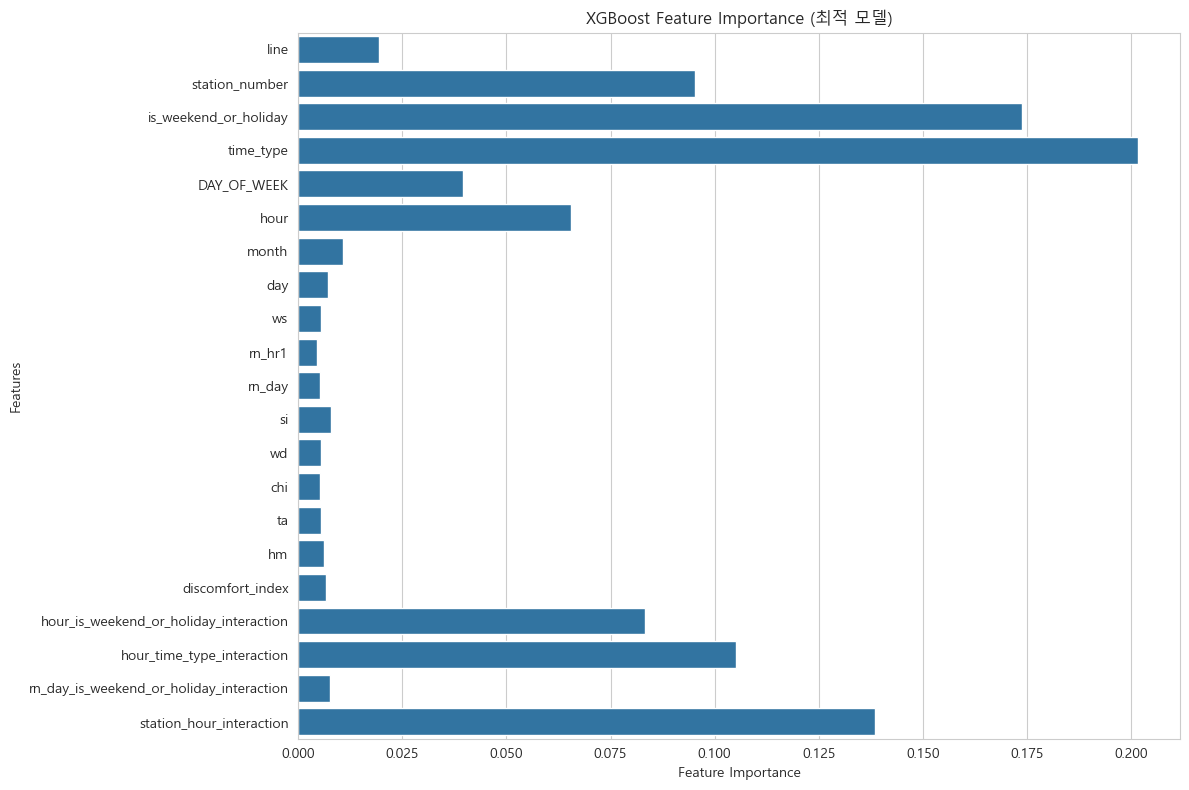


--- 최적의 하이퍼파라미터로 전체 데이터 재학습 시작 ---

✅ 최종 모델 테스트 세트 RMSE: 12.0930
✅ 최종 모델 테스트 세트 R²: 0.6649


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import uniform, randint

final_model_features = X_vif_all.columns.tolist()

# ⚡ 하이퍼파라미터 튜닝 (RandomizedSearchCV)
# X와 y 데이터 준비 (전체 df_encoded 사용)
X_full = df_encoded[final_model_features] # 모든 특성 변수 사용
y_full = df_encoded[target]

# --- 중요: RandomizedSearchCV에 전달할 데이터 샘플링 ---
# 데이터가 매우 크므로, 튜닝을 위한 샘플링을 먼저 수행합니다.
# 예를 들어, 전체 데이터의 10% 또는 특정 개수(예: 50만 개)를 샘플링합니다.
# 여기서는 50만 개를 샘플링하는 예시입니다. 필요에 따라 개수를 조절하세요.
sample_size_for_tuning = 500000 # 50만 개 (전체 데이터의 약 10%)
if len(X_full) > sample_size_for_tuning:
    sample_indices = np.random.choice(len(X_full), sample_size_for_tuning, replace=False)
    X = X_full.iloc[sample_indices]
    y = y_full.iloc[sample_indices]
else: # 데이터가 샘플링 크기보다 작으면 전체 사용
    X = X_full
    y = y_full

print(f"\n--- 하이퍼파라미터 튜닝에 사용할 데이터 크기: {len(X)} ---")


# 하이퍼파라미터 탐색 범위 정의
param_distributions = {
    'n_estimators': randint(100, 1000), # 트리의 개수
    'learning_rate': uniform(0.01, 0.1), # 학습률
    'max_depth': randint(3, 10), # 트리의 최대 깊이
    'subsample': uniform(0.6, 0.4), # 각 트리 학습에 사용할 샘플 비율
    'colsample_bytree': uniform(0.6, 0.4), # 각 트리 학습에 사용할 특성 비율
    'gamma': uniform(0, 0.2), # 리프 노드 분할에 필요한 최소 손실 감소
    'reg_alpha': uniform(0, 0.1), # L1 정규화
    'reg_lambda': uniform(0, 0.1) # L2 정규화
}

# XGBoost 모델 초기화
xgb_model = XGBRegressor(tree_method="gpu_hist", random_state=42) # n_jobs는 RandomizedSearchCV에서 설정

# K-Fold 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50, # 탐색할 조합의 수 (예시: 50개, 더 늘릴 수록 정확도 향상 가능성 높지만 시간 소요)
    scoring='neg_root_mean_squared_error', # RMSE를 최소화 (음수이므로 최대화)
    cv=kf,
    verbose=2,
    random_state=42,
    n_jobs=4 # 메모리 부담을 줄이기 위해 n_jobs를 4로 설정 (CPU 코어 수에 따라 조절)
)

# 튜닝 실행
print("\n--- 하이퍼파라미터 튜닝 시작 (RandomizedSearchCV) ---")
random_search.fit(X, y) # 샘플링된 X, y 사용

# 최적의 하이퍼파라미터와 성능 출력
print("\n✅ 최적의 하이퍼파라미터:", random_search.best_params_)
print(f"✅ 최적 모델의 교차 검증 RMSE: {-random_search.best_score_:.4f}")

# 최적의 모델 저장
best_xgb_model = random_search.best_estimator_

# 📊 Feature Importance 시각화 (최적 모델 기준)
plt.figure(figsize=(12, 8))
sns.barplot(x=best_xgb_model.feature_importances_, y=final_model_features)
plt.title("XGBoost Feature Importance (최적 모델)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# 최종 모델 평가 (테스트 세트)
# 전체 데이터셋을 X, y로 분할했으므로, 다시 train_test_split을 수행하여 최종 테스트
# 여기서는 전체 데이터 X_full, y_full을 사용하여 최종 모델을 평가합니다.
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# 최적의 하이퍼파라미터로 전체 학습 데이터에 대해 모델 재학습 (선택 사항)
# 튜닝된 모델은 샘플링된 데이터로 학습되었으므로, 최종 평가 전에 전체 데이터로 다시 학습하는 것이 일반적입니다.
print("\n--- 최적의 하이퍼파라미터로 전체 데이터 재학습 시작 ---")

# 1. best_xgb_model의 파라미터를 가져옵니다.
params = best_xgb_model.get_params()

# 2. 필요한 경우 특정 파라미터를 업데이트하거나 추가합니다.
# (이 부분은 best_xgb_model에 이미 tree_method와 random_state가 설정되어 있으므로,
#  대부분의 경우 추가적인 수정 없이 params만 사용하면 됩니다.)
# params['tree_method'] = "gpu_hist"
# params['random_state'] = 42

# 3. 업데이트된 파라미터로 XGBRegressor를 초기화합니다.
final_model_for_evaluation = XGBRegressor(**params) # **params만 사용

final_model_for_evaluation.fit(X_train_final, y_train_final)

final_preds = final_model_for_evaluation.predict(X_test_final)
final_rmse = np.sqrt(mean_squared_error(y_test_final, final_preds))
final_r2 = r2_score(y_test_final, final_preds)

print(f"\n✅ 최종 모델 테스트 세트 RMSE: {final_rmse:.4f}")
print(f"✅ 최종 모델 테스트 세트 R²: {final_r2:.4f}")

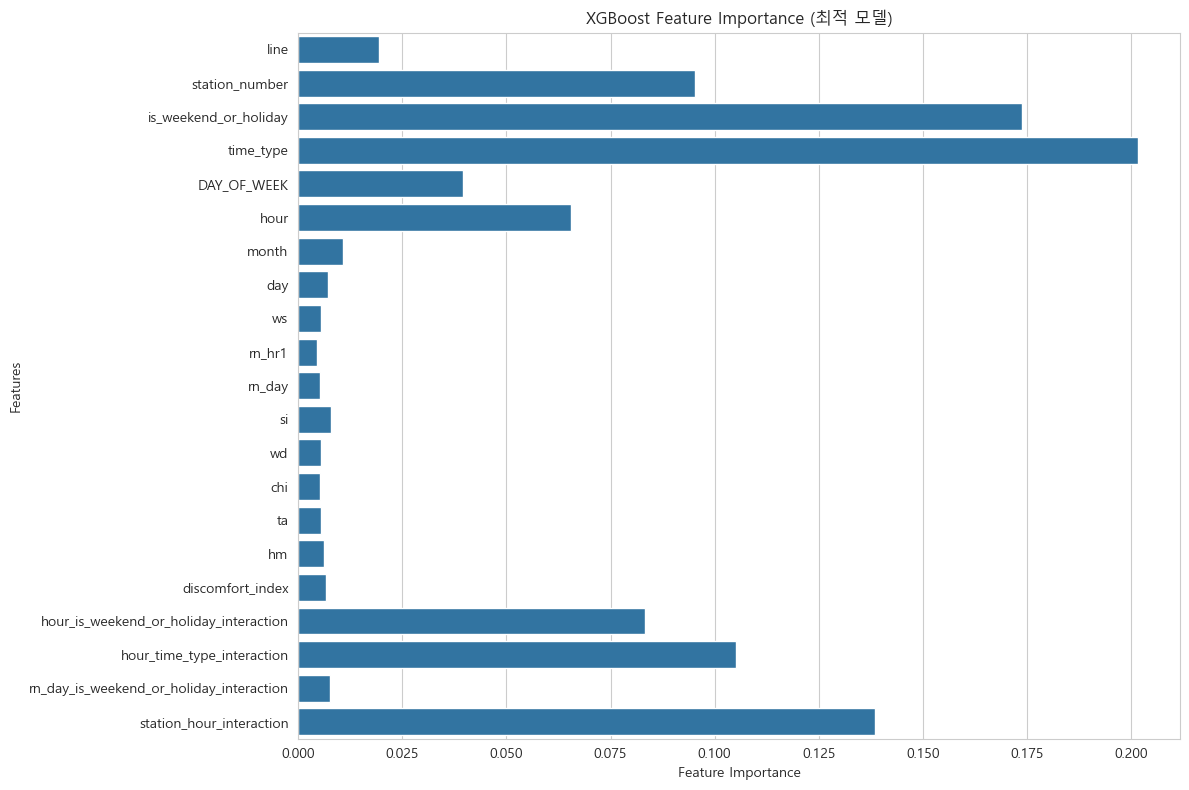


--- 최적의 하이퍼파라미터로 전체 데이터 재학습 시작 ---

✅ 최종 모델 테스트 세트 RMSE: 12.0930
✅ 최종 모델 테스트 세트 R²: 0.6649


In [ ]:
# 최적의 모델 저장
best_xgb_model = random_search.best_estimator_

# 📊 Feature Importance 시각화 (최적 모델 기준)
plt.figure(figsize=(12, 8))
sns.barplot(x=best_xgb_model.feature_importances_, y=final_model_features)
plt.title("XGBoost Feature Importance (최적 모델)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# 최종 모델 평가 (테스트 세트)
# 전체 데이터셋을 X, y로 분할했으므로, 다시 train_test_split을 수행하여 최종 테스트
# 여기서는 전체 데이터 X_full, y_full을 사용하여 최종 모델을 평가합니다.
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# 최적의 하이퍼파라미터로 전체 학습 데이터에 대해 모델 재학습 (선택 사항)
# 튜닝된 모델은 샘플링된 데이터로 학습되었으므로, 최종 평가 전에 전체 데이터로 다시 학습하는 것이 일반적입니다.
print("\n--- 최적의 하이퍼파라미터로 전체 데이터 재학습 시작 ---")

# 1. best_xgb_model의 파라미터를 가져옵니다.
params = best_xgb_model.get_params()

# 2. 필요한 경우 특정 파라미터를 업데이트하거나 추가합니다.
# (이 부분은 best_xgb_model에 이미 tree_method와 random_state가 설정되어 있으므로,
#  대부분의 경우 추가적인 수정 없이 params만 사용하면 됩니다.)
# params['tree_method'] = "gpu_hist"
# params['random_state'] = 42

# 3. 업데이트된 파라미터로 XGBRegressor를 초기화합니다.
final_model_for_evaluation = XGBRegressor(**params) # **params만 사용

final_model_for_evaluation.fit(X_train_final, y_train_final)

final_preds = final_model_for_evaluation.predict(X_test_final)
final_rmse = np.sqrt(mean_squared_error(y_test_final, final_preds))
final_r2 = r2_score(y_test_final, final_preds)

print(f"\n✅ 최종 모델 테스트 세트 RMSE: {final_rmse:.4f}")
print(f"✅ 최종 모델 테스트 세트 R²: {final_r2:.4f}")


## 테스트 데이터셋 전처리

### 데이터 불러오기

In [34]:
test = "C:/Users/PC/Downloads/test_subway.csv"

In [35]:
try:
    test_df = pd.read_csv(test, encoding='utf-8', on_bad_lines='skip')
    print("UTF-8 인코딩으로 데이터 로드에 성공했습니다.")
except UnicodeDecodeError:
    test_df = pd.read_csv(test, encoding='cp949', on_bad_lines='skip')
    print("CP949 인코딩으로 데이터 로드에 성공했습니다.")

CP949 인코딩으로 데이터 로드에 성공했습니다.


In [36]:
test_df.columns = test_df.columns.str.lower()

In [37]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5834752 entries, 0 to 5834751
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   tm              int64  
 1   line            int64  
 2   station_number  int64  
 3   station_name    object 
 4   direction       object 
 5   stn             int64  
 6   ta              float64
 7   wd              float64
 8   ws              float64
 9   rn_day          float64
 10  rn_hr1          float64
 11  hm              float64
 12  si              float64
 13  ta_chi          float64
 14  congestion      float64
dtypes: float64(9), int64(4), object(2)
memory usage: 667.7+ MB


In [38]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 예: test_df = pd.read_csv('your_data.csv') (이미 있다고 가정)
test_df.reset_index(drop=True, inplace=True)

# ✅ 'si' 포함
target_columns = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'ta_chi', 'si']
missing_value = -99

for target_col in target_columns:
    print(f"\n\n====== '{target_col}' 컬럼 처리 시작 ======")

    df_predict = test_df[test_df[target_col] == missing_value].copy()
    df_train_candidate = test_df[test_df[target_col] != missing_value].copy()

    print(f"전체 행 수: {len(test_df)}")
    print(f"예측 대상 행 수 ({target_col} == {missing_value}): {len(df_predict)}")
    print(f"훈련 데이터 후보 수 ({target_col} != {missing_value}): {len(df_train_candidate)}")

    if len(df_predict) == 0:
        print(f"{target_col} 컬럼에 대체할 {missing_value} 값이 없어 건너뜁니다.")
        continue

    # 수치형 컬럼 중 타겟 제외
    numerical_cols = test_df.select_dtypes(include=np.number).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in [target_col, 'Unnamed: 0']]

    correlation_matrix = df_train_candidate[numerical_cols + [target_col]].corr()
    correlation_with_target = correlation_matrix[target_col].abs().sort_values(ascending=False)

    correlation_threshold = 0.1
    features = correlation_with_target[correlation_with_target > correlation_threshold].index.tolist()
    if target_col in features:
        features.remove(target_col)

    if not features:
        features = numerical_cols
        print(f"{target_col}: 상관계수 기준 만족하는 피처 없음 → 전체 수치형 컬럼 사용")

    if not features:
        print(f"{target_col}: 사용할 수 있는 피처가 없어 건너뜁니다.")
        continue

    # 결측치 처리 및 학습 데이터 정제
    X_train_temp = df_train_candidate[features].replace(missing_value, np.nan)
    df_train_cleaned = df_train_candidate[~X_train_temp.isnull().any(axis=1)].copy()

    if df_train_cleaned.empty:
        print(f"{target_col}: 훈련 데이터에 유효한 행 없음 → 건너뜀")
        continue

    X_train = df_train_cleaned[features]
    y_train = df_train_cleaned[target_col]

    X_predict = df_predict[features].replace(missing_value, np.nan)

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer.fit(X_train)
    X_predict_imputed = pd.DataFrame(imputer.transform(X_predict), columns=features, index=X_predict.index)

    # 모델 성능 평가용 분리
    X_eval_train, X_eval_test, y_eval_train, y_eval_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # ✅ XGBoost 모델 (GPU)
    model = XGBRegressor(
        n_estimators=100,
        random_state=42,
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        n_jobs=-1
    )

    model.fit(X_eval_train, y_eval_train)
    y_eval_pred = model.predict(X_eval_test)
    rmse = np.sqrt(mean_squared_error(y_eval_test, y_eval_pred))
    r2 = r2_score(y_eval_test, y_eval_pred)

    print(f"{target_col} 성능평가 - RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # 전체 데이터로 재학습 및 예측
    model.fit(X_train, y_train)
    predicted_values = model.predict(X_predict_imputed)
    predicted_series = pd.Series(predicted_values, index=X_predict.index)

    # 원본 df에 반영
    test_df.loc[predicted_series.index, target_col] = predicted_series

    print(f"{target_col}: {missing_value} 값 {len(predicted_series)}개 예측값으로 대체 완료")
    print(test_df.loc[predicted_series.index, target_col].head())
    print(f"{target_col} 컬럼 최소값 (대체 후): {test_df[target_col].min()}")




====== 'ta' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (ta == -99): 53228
훈련 데이터 후보 수 (ta != -99): 5781524


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:16:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

ta 성능평가 - RMSE: 0.8514, R²: 0.9936


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:16:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

ta: -99 값 53228개 예측값으로 대체 완료
2363     16.877474
10327    16.877474
16723     0.814480
19958    23.960361
20330    24.745586
Name: ta, dtype: float64
ta 컬럼 최소값 (대체 후): -17.1


====== 'wd' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (wd == -99): 75302
훈련 데이터 후보 수 (wd != -99): 5759450


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:16:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

wd 성능평가 - RMSE: 96.4993, R²: 0.1439


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:16:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

wd: -99 값 75302개 예측값으로 대체 완료
1299     184.538605
2252     180.319122
7616     185.876266
9263     184.538605
10216    180.319122
Name: wd, dtype: float64
wd 컬럼 최소값 (대체 후): -9.9


====== 'ws' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (ws == -99): 75302
훈련 데이터 후보 수 (ws != -99): 5759450


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:16:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

ws 성능평가 - RMSE: 0.8419, R²: 0.4937


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:16:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

ws: -99 값 75302개 예측값으로 대체 완료
1299     1.735513
2252     1.030300
7616     1.687735
9263     1.735513
10216    1.030300
Name: ws, dtype: float64
ws 컬럼 최소값 (대체 후): 0.0


====== 'rn_day' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (rn_day == -99): 129062
훈련 데이터 후보 수 (rn_day != -99): 5705690


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:16:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

rn_day 성능평가 - RMSE: 6.3346, R²: 0.4267


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:16:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

rn_day: -99 값 129062개 예측값으로 대체 완료
787    1.700097
788    1.678675
789    1.678675
790    1.238600
791    1.678675
Name: rn_day, dtype: float64
rn_day 컬럼 최소값 (대체 후): -1.1512452363967896


====== 'rn_hr1' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (rn_hr1 == -99): 131754
훈련 데이터 후보 수 (rn_hr1 != -99): 5702998


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:17:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

rn_hr1 성능평가 - RMSE: 0.9513, R²: 0.3106


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:17:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

rn_hr1: -99 값 131754개 예측값으로 대체 완료
787    0.386634
788    0.365639
789    0.365639
790    0.252377
791    0.365639
Name: rn_hr1, dtype: float64
rn_hr1 컬럼 최소값 (대체 후): -0.06277647614479065


====== 'hm' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (hm == -99): 101000
훈련 데이터 후보 수 (hm != -99): 5733752


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:17:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

hm 성능평가 - RMSE: 11.3988, R²: 0.6867


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:17:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

hm: -99 값 101000개 예측값으로 대체 완료
1299     65.131065
2354     68.464745
2363     56.399815
9263     65.131065
10318    68.464745
Name: hm, dtype: float64
hm 컬럼 최소값 (대체 후): 1.5


====== 'ta_chi' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (ta_chi == -99): 0
훈련 데이터 후보 수 (ta_chi != -99): 5834752
ta_chi 컬럼에 대체할 -99 값이 없어 건너뜁니다.


====== 'si' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (si == -99): 2366482
훈련 데이터 후보 수 (si != -99): 3468270


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:17:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

si 성능평가 - RMSE: 0.6712, R²: 0.5383


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:17:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

si: -99 값 2366482개 예측값으로 대체 완료
0    0.209054
1    0.160357
2    0.167832
3    0.221529
4    0.225197
Name: si, dtype: float64
si 컬럼 최소값 (대체 후): -0.616051435470581


In [39]:
test_df.describe()

,tm,line,station_number,stn,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,congestion
count,5.834752e+06,5.834752e+06,5.834752e+06,5.834752e+06,5.834752e+06,5.834752e+06,5.834752e+06,5.834752e+06,5.834752e+06,5.834752e+06,5.834752e+06,5.834752e+06,0.0
mean,2.024067e+09,4.115423e+00,1.739918e+03,4.295553e+02,1.465636e+01,1.810395e+02,1.591341e+00,1.786164e+00,1.420337e-01,6.536836e+01,8.761685e-01,1.492001e+01,NaN
std,3.460984e+04,2.223608e+00,1.202521e+03,1.408695e+02,1.091389e+01,1.038024e+02,1.205301e+00,8.241215e+00,1.132919e+00,1.995690e+01,8.489667e-01,1.184607e+01,NaN
min,2.024010e+09,1.000000e+00,1.500000e+02,9.800000e+01,-1.710000e+01,-9.900000e+00,0.000000e+00,-1.151245e+00,-6.277648e-02,1.500000e+00,-6.160514e-01,-2.080000e+01,NaN
25%,2.024040e+09,2.000000e+00,4.100000e+02,4.070000e+02,4.700000e+00,8.510000e+01,7.000000e-01,0.000000e+00,0.000000e+00,5.030000e+01,2.341500e-01,3.900000e+00,NaN
50%,2.024070e+09,4.000000e+00,1.910000e+03,4.180000e+02,1.570000e+01,1.968000e+02,1.400000e+00,0.000000e+00,0.000000e+00,6.580000e+01,5.536912e-01,1.600000e+01,NaN
75%,2.024100e+09,6.000000e+00,2.633000e+03,4.350000e+02,2.420000e+01,2.677000e+02,2.200000e+00,0.000000e+00,0.000000e+00,8.130000e+01,1.309521e+00,2.570000e+01,NaN
max,2.024123e+09,8.000000e+00,9.006000e+03,8.890000e+02,3.840000e+01,3.600000e+02,1.100000e+01,2.825000e+02,7.850000e+01,1.000000e+02,3.900000e+00,3.760000e+01,NaN


In [22]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 예: test_df = pd.read_csv('your_data.csv')  (이미 있다고 가정)
test_df.reset_index(drop=True, inplace=True)

target_columns = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'ta_chi']
missing_value = -99

for target_col in target_columns:
    print(f"\n\n====== '{target_col}' 컬럼 처리 시작 ======")
    
    df_predict = test_df[test_df[target_col] == missing_value].copy()
    df_train_candidate = test_df[test_df[target_col] != missing_value].copy()
    
    print(f"전체 행 수: {len(test_df)}")
    print(f"예측 대상 행 수 ({target_col} == {missing_value}): {len(df_predict)}")
    print(f"훈련 데이터 후보 수 ({target_col} != {missing_value}): {len(df_train_candidate)}")
    
    if len(df_predict) == 0:
        print(f"{target_col} 컬럼에 대체할 {missing_value} 값이 없어 건너뜁니다.")
        continue
    
    # 수치형 컬럼 중 타겟 제외
    numerical_cols = test_df.select_dtypes(include=np.number).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in [target_col, 'Unnamed: 0']]
    
    correlation_matrix = df_train_candidate[numerical_cols + [target_col]].corr()
    correlation_with_target = correlation_matrix[target_col].abs().sort_values(ascending=False)
    
    correlation_threshold = 0.1
    features = correlation_with_target[correlation_with_target > correlation_threshold].index.tolist()
    if target_col in features:
        features.remove(target_col)
    
    if not features:
        features = numerical_cols
        print(f"{target_col}: 상관계수 기준 만족하는 피처 없음 → 전체 수치형 컬럼 사용")
    
    if not features:
        print(f"{target_col}: 사용할 수 있는 피처가 없어 건너뜁니다.")
        continue
    
    X_train_temp = df_train_candidate[features].replace(missing_value, np.nan)
    df_train_cleaned = df_train_candidate[~X_train_temp.isnull().any(axis=1)].copy()
    
    if df_train_cleaned.empty:
        print(f"{target_col}: 훈련 데이터에 유효한 행 없음 → 건너뜀")
        continue
    
    X_train = df_train_cleaned[features]
    y_train = df_train_cleaned[target_col]
    
    X_predict = df_predict[features].replace(missing_value, np.nan)
    
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer.fit(X_train)
    X_predict_imputed = pd.DataFrame(imputer.transform(X_predict), columns=features, index=X_predict.index)
    
    # 모델 성능 평가용 데이터 분리
    X_eval_train, X_eval_test, y_eval_train, y_eval_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # ✅ GPU 기반 XGBoost 모델
    model = XGBRegressor(
        n_estimators=100,
        random_state=42,
        tree_method='gpu_hist',        # GPU 사용
        predictor='gpu_predictor',
        n_jobs=-1
    )
    
    model.fit(X_eval_train, y_eval_train)
    y_eval_pred = model.predict(X_eval_test)
    rmse = np.sqrt(mean_squared_error(y_eval_test, y_eval_pred))
    r2 = r2_score(y_eval_test, y_eval_pred)
    
    print(f"{target_col} 성능평가 - RMSE: {rmse:.4f}, R²: {r2:.4f}")
    
    # 전체 데이터로 재학습
    model.fit(X_train, y_train)
    predicted_values = model.predict(X_predict_imputed)
    predicted_series = pd.Series(predicted_values, index=X_predict.index)
    
    # 원본에 반영
    test_df.loc[predicted_series.index, target_col] = predicted_series
    
    print(f"{target_col}: {missing_value} 값 {len(predicted_series)}개 예측값으로 대체 완료")
    print(test_df.loc[predicted_series.index, target_col].head())
    print(f"{target_col} 컬럼 최소값 (대체 후): {test_df[target_col].min()}")




====== 'ta' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (ta == -99): 53228
훈련 데이터 후보 수 (ta != -99): 5781524


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:06:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:06:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:06:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

ta 성능평가 - RMSE: 0.9284, R²: 0.9928


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:06:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:06:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:06:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

ta: -99 값 53228개 예측값으로 대체 완료
2363     16.764078
10327    16.764078
16723    -0.596618
19958    23.773064
20330    24.401443
Name: ta, dtype: float64
ta 컬럼 최소값 (대체 후): -17.1


====== 'wd' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (wd == -99): 75302
훈련 데이터 후보 수 (wd != -99): 5759450


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:07:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

wd 성능평가 - RMSE: 96.4993, R²: 0.1439


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:07:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

wd: -99 값 75302개 예측값으로 대체 완료
1299     184.538605
2252     180.319122
7616     185.876266
9263     184.538605
10216    180.319122
Name: wd, dtype: float64
wd 컬럼 최소값 (대체 후): -9.9


====== 'ws' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (ws == -99): 75302
훈련 데이터 후보 수 (ws != -99): 5759450


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:07:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

ws 성능평가 - RMSE: 0.8549, R²: 0.5025


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:07:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

ws: -99 값 75302개 예측값으로 대체 완료
1299     1.564491
2252     1.552609
7616     1.562247
9263     1.564491
10216    1.552609
Name: ws, dtype: float64
ws 컬럼 최소값 (대체 후): 0.0


====== 'rn_day' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (rn_day == -99): 129062
훈련 데이터 후보 수 (rn_day != -99): 5705690


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:07:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

rn_day 성능평가 - RMSE: 5.7889, R²: 0.5212


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:07:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

rn_day: -99 값 129062개 예측값으로 대체 완료
787    2.409532
788    2.095265
789    2.095265
790    1.732072
791    2.537880
Name: rn_day, dtype: float64
rn_day 컬럼 최소값 (대체 후): -4.193172931671143


====== 'rn_hr1' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (rn_hr1 == -99): 131754
훈련 데이터 후보 수 (rn_hr1 != -99): 5702998


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:07:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

rn_hr1 성능평가 - RMSE: 0.6834, R²: 0.6442


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:07:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

rn_hr1: -99 값 131754개 예측값으로 대체 완료
787    0.492968
788    0.476891
789    0.476891
790    0.443573
791    0.837189
Name: rn_hr1, dtype: float64
rn_hr1 컬럼 최소값 (대체 후): -0.576958179473877


====== 'hm' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (hm == -99): 101000
훈련 데이터 후보 수 (hm != -99): 5733752


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:07:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

hm 성능평가 - RMSE: 10.4851, R²: 0.7269


c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:08:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:08:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\anaconda3\envs\codeit_env\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:08:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

hm: -99 값 101000개 예측값으로 대체 완료
1299     67.466064
2354     67.142639
2363     51.769196
9263     67.466064
10318    67.142639
Name: hm, dtype: float64
hm 컬럼 최소값 (대체 후): 1.5


====== 'ta_chi' 컬럼 처리 시작 ======
전체 행 수: 5834752
예측 대상 행 수 (ta_chi == -99): 0
훈련 데이터 후보 수 (ta_chi != -99): 5834752
ta_chi 컬럼에 대체할 -99 값이 없어 건너뜁니다.


In [25]:
test_df['chi'] = test_df['ta_chi']

In [ ]:
test_df.drop(columns=['ta_chi'], inplace=True)

In [ ]:
import pandas as pd

# 1. 날짜 추출
test_df['date_dt'] = test_df['tm'].astype(str).str[:8]
test_df['date_dt'] = pd.to_datetime(test_df['date_dt'], format='%Y%m%d')

# 2. 요일로 주말 여부 계산 (토/일 → 1)
test_df['weekday'] = test_df['date_dt'].dt.weekday
test_df['is_weekend'] = test_df['weekday'].isin([5, 6])

# 3. 2024년 공휴일 정의
holidays_2024 = [
    "2024-01-01",  # 신정
    "2024-02-09", "2024-02-10", "2024-02-11", "2024-02-12",  # 설날 연휴
    "2024-03-01",  # 삼일절
    "2024-05-05", "2024-05-06",  # 어린이날 + 대체공휴일
    "2024-05-15",  # 부처님오신날
    "2024-06-06",  # 현충일
    "2024-07-17",  # 제헌절
    "2024-08-15",  # 광복절
    "2024-09-16", "2024-09-17", "2024-09-18",  # 추석 연휴
    "2024-10-03",  # 개천절
    "2024-10-09",  # 한글날
    "2024-12-25",  # 성탄절
]
holiday_dates = pd.to_datetime(holidays_2024)
test_df['is_holiday'] = test_df['date_dt'].isin(holiday_dates)

# 4. 주말 or 공휴일 → 1, 아니면 0
test_df['is_weekend_or_holiday'] = ((test_df['is_weekend']) | (test_df['is_holiday'])).astype(int)

# 5. 불필요한 중간 컬럼 제거 (선택)
test_df.drop(columns=['weekday', 'is_weekend', 'is_holiday'], inplace=True)

# 결과 예시 확인
print(test_df[['tm', 'is_weekend_or_holiday']].head())


           tm  is_weekend_or_holiday
0  2024010100                      1
1  2024010101                      1
2  2024010102                      1
3  2024010105                      1
4  2024010106                      1


In [199]:
# 날짜형 변환 및 월 정보 추가
test_df['date_dt'] = pd.to_datetime(test_df['date_dt'])
test_df['month'] = test_df['date_dt'].dt.month  # 여기서 .dt.month 사용

# 여름철 체감온도 함수 (5~9월)
def summer_chi(ta, rh):
    try:
        tw = (
            ta * np.arctan(0.151977 * np.sqrt(rh + 8.313659)) +
            np.arctan(ta + rh) -
            np.arctan(rh - 1.676331) +
            0.00391838 * rh ** 1.5 * np.arctan(0.023101 * rh) -
            4.686035
        )
        chi = -0.2442 + 0.55399 * tw + 0.45535 * ta - 0.0022 * tw**2 - 0.00278 * tw * ta + 3.0
        return chi
    except:
        return np.nan

# 겨울철 체감온도 함수 (10~4월)
def winter_chi(ta, v):
    try:
        v_16 = v ** 0.16
        chi = 13.12 + 0.6215 * ta - 11.37 * v_16 + 0.3965 * v_16 * ta
        return chi
    except:
        return np.nan

# 전체 체감온도 계산
def calculate_chi(row):
    if 5 <= row['month'] <= 9:
        return summer_chi(row['ta'], row['hm'])
    else:
        return winter_chi(row['ta'], row['ws'])

# 계산 적용
test_df['calculated_chi'] = test_df.apply(calculate_chi, axis=1)

# 반올림
test_df['chi_rounded'] = test_df['chi'].round(1)
test_df['calculated_chi_rounded'] = test_df['calculated_chi'].round(1)

# 일치 여부 확인
test_df['is_same'] = test_df['chi_rounded'] == test_df['calculated_chi_rounded']
match_rate = test_df['is_same'].mean()

# 결과 출력
print(f'체감온도(소수 1자리 기준) 일치율: {match_rate * 100:.2f}%')


체감온도(소수 1자리 기준) 일치율: 0.46%


In [201]:
# 차이 계산 (반올림 전 기준 차이)
test_df['chi_diff'] = test_df['chi'] - test_df['calculated_chi']

# 반올림 후 기준으로 다르다고 판단된 경우 필터링
not_matched_df = test_df[test_df['is_same'] == False]

# 차이 통계
diff_stats = not_matched_df['chi_diff'].describe()

# 결과 출력
print("체감온도 불일치 구간 통계 (소수점 전 기준 차이):")
print(diff_stats)

# 절댓값 기준 평균 오차도 확인
mean_abs_error = not_matched_df['chi_diff'].abs().mean()
print(f"\n불일치한 경우 평균 절댓값 차이: {mean_abs_error:.2f}°C")


체감온도 불일치 구간 통계 (소수점 전 기준 차이):
count    5.808144e+06
mean    -1.593834e-01
std      3.489507e+00
min     -2.015360e+01
25%     -2.381021e+00
50%     -9.000308e-01
75%      2.910610e+00
max      9.040812e+00
Name: chi_diff, dtype: float64

불일치한 경우 평균 절댓값 차이: 2.86°C


In [202]:
test_df['chi'] = test_df['calculated_chi']
test_df = test_df.drop(columns=['calculated_chi_rounded', 'chi_rounded', 'calculated_chi', 'chi_diff'], axis=1)

### 불쾌지수

In [204]:
test_df['hm'].unique()

array([99.        , 99.4       , 99.6       , ..., 94.41311646,
       87.33305359, 70.1960907 ])

In [203]:
# 불쾌지수 계산 함수
def calculate_discomfort_index(ta, rh):
    try:
        return 0.81 * ta + 0.01 * rh * (0.99 * ta - 14.3) + 46.3
    except:
        return np.nan

# 적용
test_df['discomfort_index'] = test_df.apply(lambda row: calculate_discomfort_index(row['ta'], row['hm']), axis=1)

# 예시 출력
print(test_df[['ta', 'hm', 'discomfort_index']].head())


    ta    hm  discomfort_index
0  0.6  99.0         33.217060
1  0.0  99.4         32.085800
2  0.3  99.6         32.596012
3 -0.1  98.1         32.093581
4 -0.6  99.0         31.068940


In [ ]:
# 불쾌지수 등급 분류
def classify_di(di):
    if di <= 68:
        return '쾌적'
    elif di <= 75:
        return '불쾌 증가'
    elif di <= 80:
        return '절반 이상 불쾌'
    else:
        return '매우 불쾌'

test_df['di_level'] = test_df['discomfort_index'].apply(classify_di)

# 확인
print(test_df[['discomfort_index', 'di_level']].value_counts())

### 강수량

In [205]:
# 시간 강수량 합계 계산 (하루 단위)
hourly_rain_sum = test_df.groupby(['date_dt', 'station_name'])['rn_hr1'].sum().reset_index()
hourly_rain_sum.rename(columns={'rn_hr1': 'daily_rn_hr1_sum'}, inplace=True)


In [206]:
# 일 강수량 정보 추출
daily_rn_day = test_df[['date_dt', 'station_name', 'rn_day']].drop_duplicates()


In [207]:
# 병합
rain_compare = pd.merge(hourly_rain_sum, daily_rn_day, on=['date_dt', 'station_name'])

# 차이 계산
rain_compare['diff'] = (rain_compare['daily_rn_hr1_sum'] - rain_compare['rn_day']).round(2)


In [208]:
# 일치하는 경우 비율
match_rate = (rain_compare['diff'].abs() < 0.01).mean() * 100
print(f"일 강수량(rn_day)과 시간 강수량 합(rn_hr1)의 일치 비율: {match_rate:.2f}%")

# 불일치 샘플
rain_compare[rain_compare['diff'].abs() >= 0.01].head()


일 강수량(rn_day)과 시간 강수량 합(rn_hr1)의 일치 비율: 25.45%


,date_dt,station_name,daily_rn_hr1_sum,rn_day,diff
0,2024-01-01,가능,1.926877,1.484352,0.44
1,2024-01-01,가능,1.926877,0.000000,1.93
2,2024-01-01,가능,1.926877,0.197432,1.73
3,2024-01-01,가능,1.926877,0.425183,1.50
4,2024-01-01,가능,1.926877,0.384946,1.54


In [211]:
# 만약 tm 컬럼이 'YYYYMMDDHH' 형식(예: 2024010101)이라면
test_df['hour'] = test_df['tm'].astype(str).str[-2:].astype(int)

# 또는 date_dt가 datetime 타입이면
# test_df['hour'] = test_df['date_dt'].dt.hour

In [212]:
# 1. 일 강수량 계산 (date_dt + station_name 기준)
new_rn_day = test_df.groupby(['date_dt', 'station_name'])['rn_hr1'].sum().reset_index()
new_rn_day.rename(columns={'rn_hr1': 'rn_day_new'}, inplace=True)

# 2. 원본 데이터와 병합
test_df = pd.merge(test_df.drop(columns=['rn_day']), new_rn_day, on=['date_dt', 'station_name'], how='left')

# 3. 컬럼 순서 정리 (선택)
cols = test_df.columns.tolist()
# rn_day_new를 rn_day로 이름 변경하여 기존 위치로
cols[cols.index('rn_day_new')] = 'rn_day'
test_df.columns = cols
test_df.rename(columns={'rn_day_new': 'rn_day'}, inplace=True)

# 4. 확인
print(test_df[['date_dt', 'station_name', 'hour', 'rn_hr1', 'rn_day']].head(10))


     date_dt station_name  hour  rn_hr1  rn_day
0 2024-01-01          서울역     0     0.0     0.0
1 2024-01-01          서울역     1     0.0     0.0
2 2024-01-01          서울역     2     0.0     0.0
3 2024-01-01          서울역     5     0.0     0.0
4 2024-01-01          서울역     6     0.0     0.0
5 2024-01-01          서울역     7     0.0     0.0
6 2024-01-01          서울역     8     0.0     0.0
7 2024-01-01          서울역     9     0.0     0.0
8 2024-01-01          서울역    10     0.0     0.0
9 2024-01-01          서울역    11     0.0     0.0


In [210]:
test_df

,tm,line,station_number,station_name,direction,stn,ta,wd,ws,rn_hr1,hm,si,congestion,chi,date_dt,is_weekend_or_holiday,month,is_same,discomfort_index,rn_day
0,2024010100,1,150,서울역,상선,419,0.6,161.4,2.7,0.0,99.0,0.222748,NaN,0.443357,2024-01-01,1,1,False,33.217060,0.0
1,2024010101,1,150,서울역,상선,419,0.0,145.7,3.8,0.0,99.4,0.235187,NaN,-0.957510,2024-01-01,1,1,False,32.085800,0.0
2,2024010102,1,150,서울역,상선,419,0.3,171.3,3.1,0.0,99.6,0.147599,NaN,-0.177307,2024-01-01,1,1,False,32.596012,0.0
3,2024010105,1,150,서울역,상선,419,-0.1,176.0,3.0,0.0,98.1,0.140145,NaN,-0.544430,2024-01-01,1,1,False,32.093581,0.0
4,2024010106,1,150,서울역,상선,419,-0.6,174.4,3.9,0.0,99.0,0.117700,NaN,-1.684816,2024-01-01,1,1,False,31.068940,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5834747,2024123119,8,2828,남위례,하선,572,-0.2,255.7,0.2,0.0,35.1,1.133472,NaN,4.145691,2024-12-31,0,12,False,41.049202,0.0
5834748,2024123120,8,2828,남위례,하선,572,0.0,251.6,0.2,0.0,35.1,1.133472,NaN,4.331287,2024-12-31,0,12,False,41.280700,0.0
5834749,2024123121,8,2828,남위례,하선,572,-2.0,0.0,0.0,0.0,41.6,1.191267,NaN,11.877000,2024-12-31,0,12,False,37.907520,0.0
5834750,2024123122,8,2828,남위례,하선,572,-3.0,0.0,0.0,0.0,46.0,0.704653,NaN,11.255500,2024-12-31,0,12,False,35.925800,0.0


### 출근 퇴근

In [213]:
test_df['year'] = pd.to_datetime(test_df['date_dt']).dt.year
test_df['month'] = pd.to_datetime(test_df['date_dt']).dt.month
test_df['day'] = pd.to_datetime(test_df['date_dt']).dt.day
grouped_all = test_df.groupby(['year', 'month', 'hour'])[
    ['congestion', 'ta', 'hm', 'si', 'rn_hr1']
].mean().reset_index()

In [214]:
def assign_commute_time(hour):
    if 7 <= hour <= 9:
        return '출근'
    elif 17 <= hour <= 19:
        return '퇴근'
    else:
        return '기타'

test_df['출퇴근시간'] = test_df['hour'].apply(assign_commute_time)

### 모델링 전처리

In [215]:
test_df = test_df.copy()
test_df['DAY_OF_WEEK'] = test_df['date_dt'].dt.dayofweek

In [216]:
# 매핑 딕셔너리 생성
mapping = {'기타': 0, '출근': 1, '퇴근': 2}

# 값 변환 및 컬럼명 변경
test_df['time_type'] = test_df['출퇴근시간'].map(mapping)

# 기존 컬럼 삭제 (선택 사항)
test_df = test_df.drop(columns=['출퇴근시간'])

In [217]:
test_df['direction'] = test_df['direction'].map({'상선': 0, '하선': 1})

In [218]:
final_model_for_evaluation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6550083776583973, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.0682132702100517, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02134735212405891,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=514, n_jobs=None,
             num_parallel_tree=None, ...)

In [220]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5834752 entries, 0 to 5834751
Data columns (total 25 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tm                     int64         
 1   line                   int64         
 2   station_number         int64         
 3   station_name           object        
 4   direction              float64       
 5   stn                    int64         
 6   ta                     float64       
 7   wd                     float64       
 8   ws                     float64       
 9   rn_hr1                 float64       
 10  hm                     float64       
 11  si                     float64       
 12  congestion             float64       
 13  chi                    float64       
 14  date_dt                datetime64[ns]
 15  is_weekend_or_holiday  int32         
 16  month                  int32         
 17  is_same                bool          
 18  discomfort_index      

In [231]:
import pandas as pd
import numpy as np
# 필요한 라이브러리들이 이미 임포트되어 있다고 가정합니다.
# from category_encoders import TargetEncoder
# from xgboost import XGBRegressor

# --- 훈련 시 사용된 컬럼 정의를 다시 가져옵니다. ---
# 이 정의는 훈련 코드와 정확히 일치해야 합니다.
cat_cols = [
    'line', 'station_number', 'is_weekend_or_holiday', 'time_type',
    'DAY_OF_WEEK'
]

# TargetEncoder의 fit_transform에 입력되었던 수치형 및 상호작용 변수들
# (station_hour_interaction은 Target Encoding 이후에 생성되므로 여기에 포함되지 않습니다.)
num_cols_for_encoder_input = [
    'hour', 'month', 'day',
    'ws', 'rn_hr1', 'rn_day', 'si', 'wd',
    'chi', 'ta', 'hm', 'discomfort_index',
    'hour_is_weekend_or_holiday_interaction',
    'hour_time_type_interaction',
    'rn_day_is_weekend_or_holiday_interaction'
]

# 훈련 시 제거했던 컬럼 리스트
columns_to_drop_after_preprocessing = [
    'calculated_chi', 'calculated_chi_rounded', 'chi_rounded', 'is_same',
    'di_level', '출퇴근시간', 'date_dt'
]

# 최종 모델에 사용된 특성 리스트 (훈련 시 final_model_features와 동일해야 합니다.)
# 이 리스트는 Target Encoding된 범주형 변수, num_cols_for_encoder_input,
# 그리고 station_hour_interaction을 포함합니다.
final_model_features = cat_cols + num_cols_for_encoder_input + ['station_hour_interaction']

# --- test_df 전처리 시작 ---

# 원본 test_df를 직접 수정하지 않기 위해 복사본을 만듭니다.
test_df_processed = test_df.copy()

# 1. 날짜/시간 관련 파생 변수 생성
# date_dt 컬럼이 datetime 타입이 아니라면 변환합니다.
if not pd.api.types.is_datetime64_any_dtype(test_df_processed['date_dt']):
    test_df_processed['date_dt'] = pd.to_datetime(test_df_processed['date_dt'])

test_df_processed['year'] = test_df_processed['date_dt'].dt.year
test_df_processed['month'] = test_df_processed['date_dt'].dt.month
test_df_processed['day'] = test_df_processed['date_dt'].dt.day
test_df_processed['DAY_OF_WEEK'] = test_df_processed['date_dt'].dt.dayofweek

# 2. 불필요하거나 처리된 컬럼 제거
test_df_processed = test_df_processed.drop(columns=columns_to_drop_after_preprocessing, errors='ignore')

# 3. 새로운 상호작용 변수 생성 (타겟 인코딩 전)
test_df_processed['hour_is_weekend_or_holiday_interaction'] = test_df_processed['hour'] * test_df_processed['is_weekend_or_holiday']
test_df_processed['hour_time_type_interaction'] = test_df_processed['hour'] * test_df_processed['time_type']
test_df_processed['rn_day_is_weekend_or_holiday_interaction'] = test_df_processed['rn_day'] * test_df_processed['is_weekend_or_holiday']

# 4. Target Encoding 적용
# 훈련 시 사용된 `encoder` 객체를 사용하여 `transform` 메서드를 호출합니다.
# `TargetEncoder`는 `cols`에 지정된 컬럼만 인코딩하고, 나머지 컬럼은 그대로 통과시킵니다.
X_for_encoding = test_df_processed[cat_cols + num_cols_for_encoder_input].copy()
test_df_encoded_features = encoder.transform(X_for_encoding)

# 5. 타겟 인코딩된 변수를 활용한 상호작용 변수 생성 (`station_hour_interaction`)
# `station_number`는 `test_df_encoded_features` 내에서 이미 타겟 인코딩된 수치형 값입니다.
test_df_encoded_features['station_hour_interaction'] = test_df_encoded_features['station_number'] * test_df_encoded_features['hour']

# 6. 최종 모델에 사용할 특성 선택
# 훈련 시 모델에 입력된 특성들의 순서와 이름이 정확히 일치해야 합니다.
X_for_prediction = test_df_encoded_features[final_model_features]

# 7. 예측 수행
# 훈련된 `final_model_for_evaluation` 객체를 사용하여 예측을 수행합니다.
test_df['predicted_congestion'] = final_model_for_evaluation.predict(X_for_prediction)

print("\n✅ test_df에 'predicted_congestion' 컬럼이 성공적으로 추가되었습니다.")
print("\n--- 예측 결과 미리보기 (상위 5개) ---")
# 원본 congestion 컬럼이 있다면 함께 출력하여 비교해볼 수 있습니다.
if 'congestion' in test_df.columns:
    print(test_df[['congestion', 'predicted_congestion']].head())
else:
    print(test_df[['predicted_congestion']].head())

print(f"\n전체 예측이 완료된 test_df의 크기: {test_df.shape}")



✅ test_df에 'predicted_congestion' 컬럼이 성공적으로 추가되었습니다.

--- 예측 결과 미리보기 (상위 5개) ---
   congestion  predicted_congestion
0         NaN              1.723259
1         NaN              1.623245
2         NaN              3.256090
3         NaN              3.661655
4         NaN              3.319155

전체 예측이 완료된 test_df의 크기: (5834752, 26)


In [229]:
test_df['predicted_congestion']

0           1.723259
1           1.623245
2           3.256090
3           3.661655
4           3.319155
             ...    
5834747    22.436398
5834748    17.648264
5834749    17.896255
5834750    17.710747
5834751    12.776508
Name: predicted_congestion, Length: 5834752, dtype: float32

In [232]:
# 1. NaN 값이 없는 경우:
test_df['predicted_congestion'] = np.round(test_df['predicted_congestion']).astype(int)

# 2. NaN 값이 있을 수 있는 경우 (pandas 1.0 이상에서 권장):
# test_df['predicted_congestion'] = np.round(test_df['predicted_congestion']).astype('Int64')
# 'Int64'는 NaN을 허용하는 정수형 타입입니다.

print(f"\n'predicted_congestion' 컬럼의 데이터 타입이 {test_df['predicted_congestion'].dtype}로 변경되었습니다.")
print("\n--- 'predicted_congestion' 컬럼 미리보기 (상위 5개) ---")
print(test_df['predicted_congestion'].head())


'predicted_congestion' 컬럼의 데이터 타입이 int32로 변경되었습니다.

--- 'predicted_congestion' 컬럼 미리보기 (상위 5개) ---
0    2
1    2
2    3
3    4
4    3
Name: predicted_congestion, dtype: int32


In [233]:
import pandas as pd
import numpy as np

# 1. 'predicted_congestion' 컬럼명을 'Congestion'으로 변경합니다.
# test_df는 이전 단계에서 예측값이 추가된 DataFrame이라고 가정합니다.
if 'predicted_congestion' in test_df.columns:
    test_df = test_df.rename(columns={'predicted_congestion': 'Congestion'})
    print("✅ 'predicted_congestion' 컬럼명이 'Congestion'으로 성공적으로 변경되었습니다.")
else:
    print("⚠️ 'predicted_congestion' 컬럼을 찾을 수 없습니다. 이미 이름이 변경되었거나 존재하지 않을 수 있습니다.")

# 2. 변경된 'Congestion' 컬럼만 선택합니다.
if 'Congestion' in test_df.columns:
    congestion_column_df = test_df[['Congestion']] # DataFrame 형태로 저장하기 위해 이중 대괄호 사용
    
    # 3. 해당 컬럼을 'Congestion_predictions.csv' 파일로 EUC-KR 인코딩하여 저장합니다.
    output_filename = 'Congestion_predictions.csv'
    try:
        congestion_column_df.to_csv(output_filename, index=False, encoding='euc-kr')
        print(f"✅ 'Congestion' 컬럼이 '{output_filename}' 파일로 EUC-KR 인코딩되어 저장되었습니다.")
    except Exception as e:
        print(f"❌ 파일 저장 중 오류가 발생했습니다: {e}")
else:
    print("⚠️ 'Congestion' 컬럼이 존재하지 않아 파일을 저장할 수 없습니다.")

print("\n--- 'test_df'의 컬럼 목록 (이름 변경 후) ---")
print(test_df.columns.tolist())


✅ 'predicted_congestion' 컬럼명이 'Congestion'으로 성공적으로 변경되었습니다.
✅ 'Congestion' 컬럼이 'Congestion_predictions.csv' 파일로 EUC-KR 인코딩되어 저장되었습니다.

--- 'test_df'의 컬럼 목록 (이름 변경 후) ---
['tm', 'line', 'station_number', 'station_name', 'direction', 'stn', 'ta', 'wd', 'ws', 'rn_hr1', 'hm', 'si', 'congestion', 'chi', 'date_dt', 'is_weekend_or_holiday', 'month', 'is_same', 'discomfort_index', 'hour', 'rn_day', 'year', 'day', 'DAY_OF_WEEK', 'time_type', 'Congestion']


In [234]:
congestion_column_df

,Congestion
0,2
1,2
2,3
3,4
4,3
...,...
5834747,22
5834748,18
5834749,18
5834750,18
